## Imports

In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    bsm_vol_est_brute_force,
    bsm_vol_est_minimization,
    vector_vol_estimation
)
from dbase.DataAPI.ThetaData import (
    extract_numeric_value)
from datetime import date, datetime
from module_test.raw_code.optionlib_2.config.defaults import DAILY_BASIS
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    vectorized_market_forward_calc
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries, CustomCache, check_missing_dates, not_trading_day
import os
  
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    estimate_crr_implied_volatility,
    vol_est_brute_force_bjs_2002,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    get_vectorized_dividend_rate,
    get_vectorized_dividend_scehdule,
    vectorized_discrete_pv
)

from module_test.raw_code.optionlib_2.assets.dividend import (
    vector_convert_to_time_frac
)

from module_test.raw_code.optionlib_2.greeks.numerical.bjs2002 import (
    bjs2002_numerical_greeks,
)
from module_test.raw_code.optionlib_2.greeks.numerical.black_scholes import vectorized_black_scholes_greeks

from module_test.raw_code.optionlib_2.greeks.numerical.binomial import (
    binomial_tree_greeks,
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
import numpy as np
import pandas as pd
from trade.assets.rates import get_risk_free_rate_helper
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
# os.environ['PROXY_URL'] = ''
from dbase.DataAPI.ThetaData import (
    list_contracts,
    retrieve_eod_ohlc,
    retrieve_chain_bulk
)
from trade import PRICING_CONFIG, reload_pricing_config, get_pricing_config
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from weakref import WeakSet
from typing import List, Tuple, Literal
from scipy.interpolate import interp1d
from threading import Semaphore, Thread
from module_test.raw_code.optionlib_2.pricing.black_scholes import black_scholes_vectorized
from module_test.raw_code.optionlib_2.pricing.binomial import crr_binomial_pricing
from module_test.raw_code.optionlib_2.greeks.numerical.binomial import binomial_tree_price_batch
from trade.helpers.Logging import setup_logger
from pathlib import Path
from functools import wraps
from typing import Callable, Any, Optional
from dataclasses import dataclass, field
from pydantic import BaseModel, Field, ConfigDict, PrivateAttr, ValidationError
from pydantic.dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List, Optional, Literal, Dict
from scipy.interpolate import interp1d
from trade.helpers.Logging import setup_logger
import pandas as pd
from enum import Enum, auto
from concurrent.futures import ThreadPoolExecutor, Future
from dataclasses import dataclass as stdlib_dataclass, field as stdlib_field
from typing import ClassVar, Final
from dateutil.relativedelta import relativedelta
logger =setup_logger('SSVIModel', stream_log_level='INFO')


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-10-19 00:44:33 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://54.205.248.219:5500/thetadata


In [2]:
## Import Resolved

import json, hashlib

def hash_config(config_dict):
    json_bytes = json.dumps(config_dict, sort_keys=True, separators=(",", ":")).encode()
    return hashlib.sha256(json_bytes).hexdigest()

# Example
config_hash = hash_config(get_pricing_config())
config_hash

'5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328a2d36c7919adfc6bdc'

In [3]:
## Import Resolved
def is_latest_config(stored_hash: str) -> bool:
    current_hash = hash_config(get_pricing_config())
    return stored_hash == current_hash

In [4]:
def validate_ssvi_params(
    rho_hat: float,
    var0_hat: float, var_inf_hat: float, kappa_hat: float,
    eta_hat: float, lambda_hat: float,
    maturities: list[float],
) -> None:
    # ρ strict bound
    if not (-0.999999 < rho_hat < 0.999999):
        raise ValueError("rho_hat must be strictly between -1 and 1")

    # θ(T) term structure (optional, if you use it)
    for v in (var0_hat, var_inf_hat, kappa_hat, eta_hat, lambda_hat):
        if v < 0:
            raise ValueError("variance-like and scale parameters must be non-negative")

    # Monotone θ(T): θ(T)=var_inf + (var0 - var_inf) e^{-kappa T}
    if var_inf_hat < var0_hat:
        raise ValueError("Require var_inf_hat ≥ var0_hat for increasing θ(T)")

    # Butterfly cap for raw-SSVI with φ(T)=λ/√T and θ(T)=ηT
    psi_max = 4.0 / (1.0 + abs(rho_hat))
    for T in maturities:
        if T <= 0:
            continue
        if eta_hat * lambda_hat * (T ** 0.5) > psi_max:
            raise ValueError("Butterfly no-arb violated: eta*lambda*sqrt(T) exceeds 4/(1+|rho|)")


In [5]:
## Import Resolved
class BackgroundFits:
    """
    One shared, bounded thread pool for all background fits.
    - max_workers: threads running background fits concurrently
    - max_queue: limit queued-but-not-started fits (backpressure)
    Policy: if the queue is full, we SKIP the submission (non-blocking).
    """
    def __init__(self, max_workers: int = 3, max_queue: int = 25):
        self._exec = ThreadPoolExecutor(max_workers=max_workers, thread_name_prefix="ssvi-bg")
        # Semaphore counts 'in-flight' = running + queued tasks
        self._slots = Semaphore(max_queue + max_workers)
        self._futs: Dict[str, Future] = {}

    def submit(self, key: str, fn, *args, **kwargs) -> bool:
        """
        Return True if scheduled, False if skipped due to full queue.
        """

        ## _slots.acquire() is non-blocking; if it fails, we skip the job
        ## Essentially, we are counting. if it's full, we skip.
        ## Slots start with given max_queue + max_workers, acquire() reduces count by 1, release() increases count by 1
        acquired = self._slots.acquire(blocking=False)
        if not acquired:

            ## If acquire() fails, we skip the job
            logger.info("BG queue full; skipping background job %s", key)
            return False

        def _done_cb(f: Future):
            ## Release the slot after the job is done (whether success or failure)
            self._slots.release()
            exc = f.exception()
            if exc:
                logger.warning("BG job %s failed: %s", key, exc, exc_info=True)

            ## Remove from tracking dict
            self._futs.pop(key, None)

        fut = self._exec.submit(fn, *args, **kwargs)
        fut.add_done_callback(_done_cb)
        self._futs[key] = fut
        return True

    def status(self, key: str = None) -> Dict[str, str]:
        """
        Get the status of all background jobs.
        Returns a dict mapping job keys to their status: "running", "done", or "queued".
        """
        st = {}
        for k, f in list(self._futs.items()):
            st[k] = "running" if f.running() else ("done" if f.done() else "queued")
        return st if key is None else {key: st.get(key, "not found")}
    

    def shutdown(self) -> None:
        """
        Shutdown the background executor.
        """
        self._exec.shutdown(wait=False, cancel_futures=True)
        self._futs.clear()

    def restart(self) -> None:
        """
        Restart the background executor.
        """
        self.shutdown()
        self._exec = ThreadPoolExecutor(max_workers=3, thread_name_prefix="ssvi-bg")
        self._futs.clear()

In [6]:
GLOBAL_BACKGROUND_FITS = BackgroundFits(max_workers=3, max_queue=1_000)

In [7]:
## Return later
class _SingletonMixin(ABC, BaseModel):
    """
    A mixin class to make a class a singleton by symbol.
    """
    _instances: ClassVar[Dict[str, "SingletonMixin"]] = {}
    _initialized: bool = PrivateAttr(False)
    model_config = ConfigDict(arbitrary_types_allowed=True)

    def __new__(cls, symbol: str, *args, **kwargs):
        key = symbol
        if key not in cls._instances:
            instance = super().__new__(cls)
            cls._instances[key] = instance
        else:
            logger.info(f"Using cached instance for {symbol}")
        return cls._instances[key]
    
    def __init__(self, *args, **data):
        # First-time init for this cached instance:
        # If __pydantic_private__ isn't set yet, it's the first real init.
        if getattr(self, "__pydantic_private__", None) is None:
            super().__init__(*args, **data)     # sets fields and creates private store
            self._initialized = True            # safe now
            return


    @classmethod
    @abstractmethod
    def clear_instances(cls):
        pass

    @classmethod
    @abstractmethod
    def instances(cls):
        pass

## SingletonMixin

In [8]:
## Trade.helpers.types.py

class SingletonMixin(ABC):
    """
    A mixin class to make a class a singleton by symbol.
    """

    _registry: ClassVar[WeakSet[type]] = WeakSet()

    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        SingletonMixin._registry.add(cls)


    @classmethod
    @abstractmethod
    def clear_instances(cls):
        pass

    @classmethod
    @abstractmethod
    def instances(cls):
        pass

    @classmethod
    def clear_all_instances(cls) -> None:
        for sub in list(cls._registry):
            if issubclass(sub, cls):
                try:
                    sub.clear_instances()
                except TypeError:
                    pass

## Initial Vars


In [9]:
ticks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
test_start, test_valuation_date = '2025-07-16', '2025-07-16'
reload_pricing_config()
PRICING_CONFIG= get_pricing_config()

params_dump_path = Path(os.environ['GEN_CACHE_PATH']) / 'optionlib_2' / 'params_dump'
chain_dump_path = Path(os.environ['GEN_CACHE_PATH']) / 'optionlib_2' / 'chain_dumps'

PARAMS_DUMP_CACHE = CustomCache(location=params_dump_path, 
                                expire_days=300, 
                                clear_on_exit=False, 
                                fname='prod')


CHAIN_DUMP_CACHE = CustomCache(location=chain_dump_path, 
                               expire_days=300, 
                               clear_on_exit=False, 
                               fname='prod')

## Market Utility Functions

In [10]:
## trade.helpers.helper.py
def assert_member_of_enum(value: Any, enum_class: Enum) -> None:
    """
    Assert that the given value is a member of the specified Enum class.
    Raises a ValueError if the value is not a valid member.
    """
    if value not in enum_class._value2member_map_:
        raise ValueError(f"{value} is not a valid member of {enum_class.__name__}. Recieved: {value}")
    return enum_class(value)

In [11]:
## trade.helpers.pydantic.py
import sys, traceback

def loud_post_init(fn):
    def wrap(self, ctx):
        try:
            return fn(self, ctx)
        except Exception as err:
            print(f"\n[model_post_init] {type(self).__name__} crashed:", file=sys.stderr)
            traceback.print_exception(type(err), err, err.__traceback__, file=sys.stderr)
            raise
    return wrap


In [12]:
## Import resolved
## Market Utility Functions V1
def pick_random_option(tick, date):
    contracts = list_contracts(tick, date)
    # Pick a random contract from the list
    contract = np.random.choice(contracts.index)
    return contracts.iloc[contract]

def get_option_eod_price(date, contract_series):
    """
    Retrieves the end-of-day price for a given option contract on a specific date.
    
    Args:
        date (datetime): The date for which to retrieve the price.
        contract_series (pd.Series): The series containing option contract details.
        
    Returns:
        float: The end-of-day price of the option contract.
    """
    eod_data = retrieve_eod_ohlc(symbol=contract_series['root'],
                                  end_date=date,
                                  start_date=date,
                                  exp=str(contract_series['expiration']),
                                  right=contract_series['right'],
                                  strike=contract_series['strike'],
                                  )
    return eod_data.Midpoint[0]

def get_spot(tick, date, spot_type='close'):
    return retrieve_timeseries(tick, date, date, spot_type=spot_type)['close'][0]

def get_rates(date):
    """
    Retrieves the risk-free rate for a given date.
    
    Args:
        date (datetime): The date for which to retrieve the risk-free rate.
        
    Returns:
        float: The risk-free rate for the specified date.
    """
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    return get_risk_free_rate_helper()['annualized'][date]

In [13]:
## Import Resolved
def get_chain(tick: str, date: str) -> pd.DataFrame:
    """
    Retrieves the option chain for a given ticker and date, along with additional calculated fields.    
    Args:
        tick (str): The ticker symbol for the underlying asset.
        date (str): The date for which to retrieve the option chain.
    Returns:
        pd.DataFrame: A DataFrame containing the option chain with additional fields.
    """
    spot = get_spot(tick, date, spot_type='chain_price')
    date= change_to_last_busday(date)
    chain=retrieve_chain_bulk(
        tick,
        0, ## This is to get all expirations
        date,
        date,
        '16:00'
    )
    chain['spot'] = spot
    chain['valuation_date'] = date
    chain['moneyness'] = chain['Strike'] / chain['spot']
    chain['log_moneyness'] = np.log(chain['moneyness'])
    chain['T']= chain['Expiration'].apply(
        lambda x: time_distance_helper(
            x,
            date,
        ))
    chain['T'] = chain['T'].astype(float)
    chain['DTE']= chain['T'] * DAILY_BASIS

    return chain

def format_chain(chain: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the option chain DataFrame by renaming columns and converting types.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame to format.
        
    Returns:
        pd.DataFrame: The formatted option chain DataFrame.
    """
    chain.columns = chain.columns.str.lower() 
    chain['right'] = chain['right'].str.lower()
    return chain

def confine_chain_with_pricing_config(chain:pd.DataFrame) -> pd.DataFrame:
    """
    Confines the chain to the pricing configuration limits.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            expected columns: ['dte', 'moneyness']
        
    Returns:
        pd.DataFrame: The confined option chain.
    """
    conf = get_pricing_config()
    return chain[
        (chain['dte'] >= conf['VOL_SURFACE_MIN_DTE_THRESHOLD']) &
        (chain['dte'] <= conf['VOL_SURFACE_MAX_DTE_THRESHOLD']) &
        (chain['moneyness'] >= conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD']) &
        (chain['moneyness'] <= conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])
    ]
    


def get_forward_price_on_chain(chain:pd.DataFrame,
                               valuation_date:str,
                               r:float,
                               div_type:str='discrete') -> pd.DataFrame:
    """
    Calculates the forward price for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        valuation_date (str): The date of valuation.
        end_date (str): The expiration date of the option.
        r (float): The risk-free rate.
        div_type (str): Type of dividend ('discrete' or 'continuous').
        
    Returns:
        float: The calculated forward price.
    """

    ## This is per-ticker function. There must be only one ticker, one spot price
    assert len(chain['root'].unique()) == 1, "Chain must contain options from only one ticker."
    assert len(chain['spot'].unique()) == 1, "Chain must contain a single spot price."
    assert len(chain['valuation_date'].unique()) == 1, "Chain must contain a single valuation date."
    assert div_type in ['discrete', 'continuous'], "div_type must be either 'discrete' or 'continuous'."

    ## For speed, we will use unique items, and merge back later
    chain = chain.copy()
    end_dates = chain['expiration'].unique()
    valuation_dates= [valuation_date] * len(end_dates)
    S = [chain['spot'].tolist()[0]] * len(end_dates)
    tickers= [chain['root'].iloc[0]] * len(end_dates)
    r = [get_rates(valuation_date)] * len(end_dates)

    ## This function returns similar things based on div_type
    ## 1. If div_type is 'discrete', it returns the forward price, (dividend schedule & present value of dividends (It's sum of dividends))
    ## 2. If div_type is 'continuous', it returns the forward price, (dividend rate & present value of dividend rate)
    f, (actual, pv) = vectorized_market_forward_calc(
        ticks=tickers,
        S=S,
        valuation_dates=valuation_dates,
        end_dates=end_dates,
        r=r,
        div_type=div_type,
        return_div = True)
    
    ## Create a series for merging
    f = pd.Series(f, index=end_dates, name='f')
    pv = pd.Series(pv, index=end_dates, name='div_pv')

    if div_type == 'discrete':
        actual =  vector_convert_to_time_frac(
            actual,
            valuation_dates=[valuation_date] * len(actual),
            end_dates=end_dates,
        )
        


    ## Merge back to chain
    actual = pd.Series(actual, index=end_dates, name='div_schedule')
    chain = chain.merge(actual, left_on='expiration', right_index=True, how='left')
    chain = chain.merge(f, left_on='expiration', right_index=True, how='left')
    chain = chain.merge(pv, left_on='expiration', right_index=True, how='left')

    ## Calculate moneyness and log moneyness based on forward price
    chain['f_moneyness'] = chain['strike'] / chain['f']
    chain['f_log_moneyness'] = np.log(chain['f_moneyness'])

    return chain





In [14]:

## Import Resolved
## Volatility Calculation Functions
def get_bs_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str,
        rate_col_name:str=None,
        forward_col_name:str='f',
        mid_col_name:str='midpoint'
) -> pd.Series:
    """
    Estimates the Black-Scholes implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated Black-Scholes implied volatility for the option chain.
    """
    if rate_col_name is None:
        _r = [get_rates(valuation_date)] * len(chain)
    else:
        _r = chain[rate_col_name]
    
    params = list(zip(
        chain[forward_col_name if forward_col_name in chain.columns else 'f'], 
        chain['strike'], 
        chain['t'],
        _r, 
        chain[mid_col_name if mid_col_name in chain.columns else 'midpoint'], 
        chain['right'].str.lower()
    ))

    return vector_batch_processor(
        vector_vol_estimation,
        bsm_vol_est_brute_force,
        params,

    )


def get_discrete_crr_vol_on_chain(
        chain:pd.DataFrame,
        valuation_date:str,
        rates_col_name:str=None,
        div_type:str='discrete',
        N:int=250
) -> pd.Series:
    """
    Estimates the discrete CRR implied volatility for a given option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
            Expected Columns: `spot`, `strike`, `t`, `midpoint`, `div_schedule`, `right`.
        valuation_date (str): The date of valuation.
        
    Returns:
        pd.Series: The estimated discrete CRR implied volatility for the option chain.
    """
    ## Get risk-free rates
    if rates_col_name is None:
        _r = [get_rates(valuation_date)] * len(chain)
    else:
        _r = chain[rates_col_name].tolist()

    ## Pick div based on div_type
    if div_type not in ['discrete', 'continuous']:
        raise ValueError("div_type must be either 'discrete' or 'continuous'.")
    elif div_type == 'continuous':
        divs = chain['div_pv'].tolist()
    else:
        divs = chain['div_schedule'].tolist()

    crr_vector_params_discrete = list(zip(
        chain['spot'], chain['strike'].tolist(), ## Spot, Strike
        chain['t'], _r,  ## Time to Maturity, Risk Free Rate
        chain['midpoint'], ## Midpoint Price
        divs, ## Dividends based on div_type
        chain['right'].str.lower().tolist(), ## Option Type
        [N] * len(chain),  ## Number of Steps
        [div_type] * len(chain), ## Dividend Type
        [True] * len(chain),)) ## American==True, European==False
    

    return vector_batch_processor(
        vector_vol_estimation,
        estimate_crr_implied_volatility,
        crr_vector_params_discrete
    )




## Chain Prep Checklist

In [15]:
## Import Resolved
def intrinsic_value(
    strike: float,
    spot: float,
    right: Literal['c', 'p']
) -> float:
    """
    Calculate the intrinsic value of an option.
    
    Args:
        strike (float): The strike price of the option.
        spot (float): The current spot price of the underlying asset.
        right (Literal['c', 'p']): The type of option ('c' for call, 'p' for put).
        
    Returns:
        float: The intrinsic value of the option.
    """
    if right.lower() == 'c':
        return max(0, spot - strike)
    elif right.lower() == 'p':
        return max(0, strike - spot)
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'.")
    
    

def vector_eu_boundary(
        f: np.ndarray,
        strike: np.ndarray,
        t: np.ndarray,
        r: np.ndarray,
        right: np.ndarray,

) -> np.ndarray:
    """
    Calculate the European option boundary values.
    
    Args:
        f (np.ndarray): Forward prices.
        strike (np.ndarray): Strike prices.
        t (np.ndarray): Time to maturity.
        r (np.ndarray): Risk-free rates.
        right (np.ndarray): Option types ('c' for call, 'p' for put).
        
    Returns:
        np.ndarray: The boundary values of the European options.
    """
    f = np.asarray(f)
    strike = np.asarray(strike)
    t = np.asarray(t)
    r = np.asarray(r)
    right = np.asarray(right)
    if f.shape != strike.shape or f.shape != t.shape or f.shape != r.shape or f.shape != right.shape:
        raise ValueError("All input arrays must have the same shape.")

    intrinsic_values = np.zeros_like(f)
    call = right == 'c'
    put = right == 'p'
    intrinsic_values[call] = np.maximum(0, f[call] - strike[call])
    intrinsic_values[put] = np.maximum(0, strike[put] - f[put])
    boundary = intrinsic_values * np.exp(-r * t)
    return boundary

In [16]:
## Import Resolved
class ChainChecklist:
    """
    A class to perform various checks and transformations on option chain data.
    This class includes methods to prepare the chain, remove junk quotes, and more.
    """


    @staticmethod
    def chain_prep(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Prepares the option chain DataFrame for further processing.
        Runs through various transformations.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The prepared option chain DataFrame.
        """
        pass



    @staticmethod
    def remove_junk_quotes(chain:pd.DataFrame) -> pd.DataFrame:
        """
        Removes junk quotes from the option chain DataFrame.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            
        Returns:
            pd.DataFrame: The cleaned option chain DataFrame.
        """
        
        chain = chain.copy()

        ## Format chain
        chain = format_chain(chain)
        logger.info(f"Initial chain length: {len(chain)}")
        ## Drop midpoint < intrinsic value
        chain['intrinsic_value'] = chain.apply(
            lambda x: intrinsic_value(
                x['strike'], 
                x['f'], ## Use Forward Price for intrinsic value instead of spot price
                x['right']
            ), axis=1)

        ## Drop below European lower bound
        chain['eu_lower_bound'] = vector_eu_boundary(
            chain['f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            [get_rates(chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(chain),
            chain['right'].str.lower().tolist()
        )
        
        ## American Options cannot be worth less than max(intrinsic value, european lower bound, 0)
        ## Less than intrinsic value: Exercise
        ## Less than european lower bound: Arbitrage Violation
        chain['lower_bound'] = chain.apply(lambda x: max( 
            # x['intrinsic_value'],
            x['eu_lower_bound'],
            0), axis=1)
        
        ## Upper Bound is Spot for Call, Strike for Put
        chain['upper_bound'] = chain.apply(lambda x: x['spot'] if x['right'] == 'c' else x['strike'], axis=1)
        chain = chain[chain['midpoint'] >= chain['lower_bound']]
        logger.info(f"Chain length after dropping below lower bound: {len(chain)}")
        chain = chain[chain['midpoint'] <= chain['upper_bound']]
        logger.info(f"Chain length after dropping above upper bound: {len(chain)}")

        ## Confine chain with pricing config
        chain = confine_chain_with_pricing_config(chain)
        logger.info(f"Chain length after confining with pricing config: {len(chain)}")

        return chain
    
    @staticmethod
    def get_european_price(
        chain:pd.DataFrame,
        bs_vol: np.ndarray,
        forward_col_name: str = 'f',
        rates_col_name: str = None
        ) -> pd.Series:
        """
        Calculates the European price for the options in the chain.
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
        Returns:
            pd.Series: The European price for each option in the chain.
        """
        if rates_col_name is None:
            _r = [get_rates(chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'))] * len(chain)
        else:
            _r = chain[rates_col_name].tolist()

        
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        european_price_params = [
            chain[forward_col_name if forward_col_name in chain.columns else 'f'].tolist(),
            chain['strike'].tolist(),
            chain['t'].tolist(),
            _r,  # Risk-free rate
            bs_vol,
            chain['right'].str.lower().tolist(),
        ]


        european_midpoint = black_scholes_vectorized(*european_price_params)
        return pd.Series(european_midpoint, index=chain.index)
    
    @staticmethod
    def get_american_price(chain: pd.DataFrame,
                           sigmas: np.ndarray,
                           rates_col_name: str = None,
                           N: int = 500) -> pd.Series:
        """
        Calculates the American price for the options in the chain using a binomial tree.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.Series: The American price for each option in the chain.
        """
        chain = chain.copy()
        val_date = chain['valuation_date'].iloc[0].strftime('%Y-%m-%d')
        if rates_col_name is None:
            _r = [get_rates(val_date)] * len(chain)
        else:
            _r = chain[rates_col_name].tolist()
        crr_params = [
            chain['strike'].tolist(),
            chain['expiration'].tolist(),
            sigmas,
            _r,  # Risk-free rate
            [N] * len(chain),  # Number of steps
            chain['spot'].tolist(),
            ['discrete'] * len(chain),  # Dividend type
            chain['div_schedule'].tolist(),  # Dividend schedules
            chain['right'].str.lower().tolist(),
            chain['valuation_date'].tolist(),  # Start dates
            chain['valuation_date'].tolist(),  # Valuation dates
            [True] * len(chain),  # American options
        ]

        def batch_hacked(*args):
            """
            A batch processor to handle the CRR binomial pricing.
            """
            return binomial_tree_price_batch(*args)[0]
        
        american_midpoint = vector_batch_processor(
            batch_hacked,
            *crr_params
        )
        chain['american_midpoint'] = american_midpoint
        return pd.Series(american_midpoint, index=chain.index)

    @staticmethod
    def run_calc_task(chain: pd.DataFrame, 
                      seed_vol: List[float],
                      N: int = 500,
                      forward_col_name: str = 'f',
                      rates_col_name: str = None
                      ) -> pd.DataFrame:
        """
        Calculates the European equivalent prices for the options in the chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
            N (int): The number of steps in the binomial tree.
            
        Returns:
            pd.DataFrame: The option chain DataFrame with European equivalent prices.
        """
        chain = chain.copy()
        mid = chain['midpoint'].to_numpy()

        ## Using bs_vol as seed because it is backed out of the midpoint
        # seed_vol = list(chain['bs_vol'].to_numpy())

        ## Using Midpoint as initial European price because seed_vol is backed out of it
        p_eu_init = ChainChecklist.get_european_price(chain=chain, 
                                                      bs_vol=seed_vol,
                                                      forward_col_name=forward_col_name,
                                                      rates_col_name=rates_col_name)

        ## Calculate American prices using CRR Binomial model and Seed Vol
        p_am = ChainChecklist.get_american_price(chain=chain, 
                                                 sigmas=seed_vol, 
                                                 N=N,
                                                 rates_col_name=rates_col_name)

        ## Calculate Early Exercise Premium (EEP) and European Equivalent Price
        EEP = np.array(p_am - p_eu_init)
        euro_eq_mid = list(mid - EEP)

        ## Calculate European equivalent volatilities
        sigmas = ChainChecklist.get_bs_vol_on_chain(
            chain,
            chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'),
            euro_eq_mid,
            rate_col_name=rates_col_name,
            forward_col_name=forward_col_name
        )

        chain['european_midpoint'] = p_eu_init
        chain['european_vols_equiv'] = sigmas
        chain['american_midpoint'] = p_am
        chain['early_exercise_premium'] = EEP
        chain['european_equivalent_mid'] = euro_eq_mid
        return chain
    
    @staticmethod
    def calculate_european_equivalent_vols(chain: pd.DataFrame, 
                                           N: int = 500, 
                                           iteration: int = 4,
                                           seed_vol_col:str = None,
                                           forward_col_name: str = 'f',
                                           rates_col_name: str = None, 
                                           valuation_date: str|datetime = None
                                           ) -> pd.DataFrame:
        """
        Iterates the run_calc_task to refine the European equivalent prices and volatilities.
        """

        def _name_not_include_error(col_name: str, columns: pd.Index) -> bool:
            if col_name not in columns:
                raise ValueError(f"{col_name} not found in chain columns: {columns.tolist()}")
            return False

        ## Valuation date validation
        if valuation_date is None:
            try:
                valuation_date = pd.to_datetime(chain['valuation_date'].iloc[0])
            except Exception as e:
                raise ValueError("valuation_date must be provided if chain does not contain 'valuation_date' column.") from e
        else:
            valuation_date = pd.to_datetime(valuation_date)

        if rates_col_name is None:
            rates_col_name = 'risk_free_rate' 
            
        ## Rates column validation
        if rates_col_name not in chain.columns:
            if rates_col_name != 'risk_free_rate':
                print(f"Warning: {rates_col_name} not found in chain columns. Defaulting to 'risk_free_rate'.")
            rates_col_name = 'risk_free_rate'
            chain[rates_col_name] = get_rates(valuation_date.strftime('%Y-%m-%d'))


        ## Seed Vol column validation
        if seed_vol_col is None:
            seed_vol_col = 'bs_vol'
            chain[seed_vol_col] = get_bs_vol_on_chain(
                chain=chain,
                valuation_date=chain['valuation_date'].iloc[0].strftime('%Y-%m-%d'),
                mid_col_name='midpoint',
                rate_col_name=rates_col_name,
                forward_col_name=forward_col_name
            )
        
        ## Seed vol column validation P2
        elif seed_vol_col not in chain.columns:
            _name_not_include_error(seed_vol_col, chain.columns)
        
        ## Forward column validation
        _name_not_include_error(forward_col_name, chain.columns) 


        ## Begin process
        seed_vol = list(chain[seed_vol_col].to_numpy())
        for i in range(iteration):
            print(f"Iteration {i+1} of {iteration}")
            chain = ChainChecklist.run_calc_task(chain,
                                                 seed_vol, 
                                                 N, 
                                                 forward_col_name=forward_col_name,
                                                 rates_col_name=rates_col_name)

            if i == iteration - 1:
                break ## Last iteration, no need to reset variables
            
            ## Reset Variables for rerun
            seed_vol = list(chain['european_vols_equiv'].to_numpy())
        return chain

    
    @staticmethod
    def get_bs_vol_on_chain(
        chain: pd.DataFrame,
        valuation_date: str,
        midpoints: pd.Series,
        rate_col_name: str = None,
        forward_col_name: str = 'f'
    ) -> pd.Series:
        """
        Estimates the Black-Scholes implied volatility for a given option chain.
        
        Args:
            chain (pd.DataFrame): The option chain DataFrame.
                Expected Columns: `f`, `strike`, `t`, `midpoint`, `right`. 
            valuation_date (str): The date of valuation.
            
        Returns:
            pd.Series: The estimated Black-Scholes implied volatility for the option chain.
        """
        if rate_col_name is None:
            _r = [get_rates(valuation_date)] * len(chain)   

        else:
            _r = chain[rate_col_name]
        params = list(zip(
            chain[forward_col_name if forward_col_name in chain.columns else 'f'], 
            chain['strike'], 
            chain['t'],
            _r,
            midpoints, 
            chain['right'].str.lower()
        ))
        return vector_batch_processor(
            vector_vol_estimation,
            bsm_vol_est_brute_force,
            params,
        )


## SSVI Utilities

In [17]:
import numpy as np
from typing import List, Tuple, Callable
import math
from trade.helpers.pools import runProcesses

# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

def make_candidate(bounds: List[Tuple[float, float]], iterations) -> np.ndarray:
    """
    Generate a random candidate solution within the given bounds.
    bounds: list of (low, high) for each dimension
    """
    rng = np.random.default_rng(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])

    # (iterations, d) matrix of uniform random samples
    candidates = low + (high - low) * rng.random((iterations, len(bounds)))
    return candidates


def random_search_vec(objective_multi: Callable[[np.ndarray], np.ndarray],
                      bounds: List[Tuple[float, float]],
                      iterations: int = 40_000) -> Tuple[np.ndarray, float]:
    """
    Vectorised random search.
    objective_multi: accepts an (N, d) array -> returns (N,) array of losses
    bounds         : list of (low, high) for each dimension
    iterations     : how many random draws
    """

    # vectorised loss evaluation -> (iterations,)
    candidates = make_candidate(bounds, iterations)
    _losses = objective_multi(candidates)
    best_idx = np.argmin(_losses)
    return candidates[best_idx], _losses[best_idx]


def atm_loss_multi(X, t, iv_atm):
    """
    X : (N, 3)  – rows = [var0, var_inf, kappa]
    t, iv_atm   – market ATM maturities and vols (1-D)
    returns     – loss for each row  (shape (N,))
    """
    var0, var_inf, kappa = X[:, 0], X[:, 1], X[:, 2]
    theta_t  = atm_total_variance(t[:, None], var0, var_inf, kappa)  # broadcast
    model_iv = np.sqrt(theta_t / t[:, None])
    mse      = ((model_iv - iv_atm[:, None])**2).mean(axis=0)        # → (N,)

    # guard against NaN / huge vols
    invalid   = (np.isinf(mse)) | (np.isnan(mse))
    mse = np.where(invalid, 1e4, mse)  # penalise
    return mse

def surface_loss_multi(params_mat, K_grid, T_grid, fwd,
                       var0_hat, var_inf_hat, kappa_hat,
                       market_iv, weights=None):
    """
    params_mat : (N,3) rows [eta, lambda, rho]
    returns    : (N,)   weighted MSE per candidate
    """
    eta, lam, rho = params_mat.T
    M = K_grid.shape[0]

    # normalize weights -> (M,)
    if weights is None:
        weights = np.ones(M, dtype=float)
    else:
        weights = np.asarray(weights, dtype=float)
        if weights.ndim != 1 or weights.shape[0] != M:
            raise ValueError(f"weights must be shape ({M},), got {weights.shape}")

    bad = (eta <= 0) | (lam <= -0.9) | (lam >= 1.0) | (np.abs(rho) >= 0.999)
    safe_eta = np.where(bad, 1.0, eta)
    safe_lam = np.where(bad, 0.0, lam)
    safe_rho = np.where(bad, 0.0, rho)

    k = np.log(K_grid / fwd)[:, None]     # (M,1)
    T = T_grid[:, None]                   # (M,1)
    theta = atm_total_variance(T, var0_hat, var_inf_hat, kappa_hat)

    total_var = ssvi_total_variance(
        k, theta, safe_eta[None, :], safe_lam[None, :], safe_rho[None, :]
    )                                      # (M,N)

    iv_model = np.sqrt(total_var / T)      # (M,N)
    invalid = (~np.isfinite(iv_model)) | (iv_model > 5)
    iv_model = np.where(invalid, 1e4, iv_model)

    sqerr = (iv_model - market_iv[:, None]) ** 2   # (M,N)

    # ✅ weighted mean over M → shape (N,)
    wmse = np.average(sqerr, axis=0, weights=weights)

    # slam bad candidates
    wmse = np.where(bad, 1e9, wmse)
    return wmse






In [18]:
def _loss_chunk_with_idx(idx,
                         params_chunk,
                         K_grid, T_grid, fwd,
                         var0_hat, var_inf_hat, kappa_hat,
                         market_iv):
    # Call your original function on a chunk
    mse = surface_loss_multi(params_chunk,
                             K_grid, T_grid, fwd,
                             var0_hat, var_inf_hat, kappa_hat,
                             market_iv)
    return idx, mse  # keep index so we can reassemble in order


def surface_loss_multi_parallel(params_mat,
                                K_grid, T_grid, fwd,
                                var0_hat, var_inf_hat, kappa_hat,
                                market_iv,
                                *,
                                chunk_size=1024,
                                run_type='imap'):
    """
    Parallel wrapper around surface_loss_multi using runProcesses.
    params_mat: (N,3) -> returns (N,)
    No globals; constants are passed to each worker.
    """
    N = int(params_mat.shape[0])
    if N == 0:
        return np.empty((0,), dtype=float)

    # 1) Make chunks
    chunks = [params_mat[i:min(i+chunk_size, N)] 
              for i in range(0, N, chunk_size)]
    idxs   = list(range(len(chunks)))
    n      = len(chunks)

    # 2) Build OrderedInputs for your runProcesses(func, [args1, args2, ...])
    OrderedInputs = [
        idxs,
        chunks,
        [K_grid]      * n,
        [T_grid]      * n,
        [fwd]         * n,
        [var0_hat]    * n,
        [var_inf_hat] * n,
        [kappa_hat]   * n,
        [market_iv]   * n,
    ]

    # 3) Fan out
    results = runProcesses(_loss_chunk_with_idx, OrderedInputs, run_type=run_type)

    # 4) Materialize depending on run_type
    if run_type == 'amap':              # async ordered
        results = results.get()
    elif run_type in ('imap', 'uimap'): # iterator / unordered
        results = list(results)

    # 5) Reassemble in original order of rows
    results.sort(key=lambda x: x[0])                 # by chunk index
    mse_chunks = [m for _, m in results]
    return np.concatenate(mse_chunks, axis=0)


In [19]:
def get_atm_vol(chain: pd.DataFrame,
                log_moneyness_col_name: str='log_moneyness',
                vol_col_name: str='crr_vol_discrete') -> pd.Series:
    """
    Finds the ATM volatility for a given expiration in the chain.
    Args:
        x (pd.DataFrame): The option chain DataFrame for a specific expiration.
    Returns:
        float: The ATM volatility for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x[log_moneyness_col_name]).min()
        return x[x[log_moneyness_col_name].abs() == min_l_m][vol_col_name].values[0]
    return chain.groupby('expiration').apply(finder).values

def get_atm_T(chain: pd.DataFrame,
               log_moneyness_col_name: str='log_moneyness',
               t_col_name: str='t') -> pd.Series:
    """
    Finds the ATM time to expiration for a given expiration in the chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame for a specific expiration.
        
    Returns:
        pd.Series: The ATM time to expiration for the given expiration.
    """
    def finder(x):
        min_l_m= abs(x[log_moneyness_col_name]).min()
        return x[x[log_moneyness_col_name].abs() == min_l_m][t_col_name].values[0]
    return chain.groupby('expiration').apply(finder).values


def get_best_params(T_atm: List[float],
                    iv_atm: List[float]) -> Tuple[np.ndarray, float]:
    """
    Find the best parameters for the ATM term structure.
    Returns:
        var0_hat, var_inf_hat, kappa_hat
    """
    bounds = [(1e-4, 0.2), # var0: Min ATM Variance across DTE
              (1e-4, 0.2), # var_inf_hat: Max ATM Variance across DTE
              (0.05, 3.0)] # kappa: Speed from var0 to var_inf_hat
    best_params, best_loss = random_search_vec(
        lambda X: atm_loss_multi(X, T_atm, iv_atm),
        bounds,
        iterations=3000
    )
    return best_params, best_loss


In [20]:

def get_surface_params(
        k_grid: np.ndarray,
        t_grid: np.ndarray,
        fwd_grid: float,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        market_iv_grid: np.ndarray,
        iterations: int = 50_000,
        chunk_size: int = None
) -> Tuple[float, float, float, float]:
        """
        Estimate the SSVI surface parameters (eta, lambda, rho) using random search.
        Args:
        k_grid (np.ndarray): The strike prices.
        t_grid (np.ndarray): The maturities.
        fwd_grid (float): The forward price.
        var0_hat (float): Estimated initial variance.
        var_inf_hat (float): Estimated long-term variance.
        kappa_hat (float): Estimated speed of mean reversion.
        market_iv_grid (np.ndarray): Market implied volatilities.
        iterations (int): Number of random search iterations.
        chunk_size (int): Size of chunks for parallel processing.
        Returns:
        Tuple[float, float, float, float]: Estimated parameters (eta, lambda, rho) and best loss.
        """
        if chunk_size is None:
            chunk_size = int(iterations / 8)

        # 1 tighter parameter bounds v1
        surf_bounds = [(0.05, 1.5),      # eta
                        (-0.8, 0.8),      # lambda
                        (-0.95, 0.95)]    # rho
        

        surface_lamba = lambda X: surface_loss_multi_parallel(X, K_grid=k_grid, 
                                                        T_grid=t_grid,
                                                        fwd=fwd_grid,
                                                        var0_hat=var0_hat,
                                                        var_inf_hat=var_inf_hat,
                                                        kappa_hat=kappa_hat,
                                                        market_iv=market_iv_grid,
                                                        chunk_size=chunk_size)
        (eta_hat, lambda_hat, rho_hat), best_loss = random_search_vec(surface_lamba,
                                                                      surf_bounds, 
                                                                      iterations)

        return eta_hat, lambda_hat, rho_hat, best_loss



In [21]:
## Getters
## Import Resolved
def get_K_grid(chain:pd.DataFrame, col_name: str='strike') -> np.ndarray:
    """
    Retrieves the strike prices from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        col_name (str): The column name to retrieve (default is 'strike').
        
    Returns:
        np.ndarray: The strike prices for the option chain.
    """
    return chain[col_name].values

def get_T_grid(chain:pd.DataFrame, col_name: str='t') -> np.ndarray:
    """
    Retrieves the maturities from the option chain.

    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        col_name (str): The column name to retrieve (default is 't').
    Returns:
        np.ndarray: The maturities for the option chain.
    """
    return chain[col_name].values

def get_T_grid(chain:pd.DataFrame, col_name: str='t') -> np.ndarray:
    """
    Retrieves the maturities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        col_name (str): The column name to retrieve (default is 't').
    Returns:
        np.ndarray: The maturities for the option chain.
    """
    return chain[col_name].values

def get_market_iv_grid(chain:pd.DataFrame, col_name: str='iv') -> np.ndarray:
    """
    Retrieves the market implied volatilities from the option chain.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        col_name (str): The column name to retrieve (default is 'iv').
        
    Returns:
        np.ndarray: The market implied volatilities for the option chain.
    """
    return chain[col_name].values

def get_fwd_grid(chain:pd.DataFrame, col_name: str='f') -> float:
    """
    Retrieves the forward price from the option chain.

    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        col_name (str): The column name to retrieve (default is 'f').
    """
    return chain[col_name].iloc[0]  # Assuming F is constant across the chains



In [22]:
## Import Resolved
def calculate_normalized_rmse_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray,
) -> Tuple[float, float, float]:
    
    """
    Calculate the normalized loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median loss, right wing loss, left wing loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_loss = np.sqrt(np.mean((market_iv - model_iv)**2)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_loss = np.sqrt(np.mean(
        (market_iv[right_wing_mask] - model_iv[right_wing_mask]) **2)) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_loss = np.sqrt(np.mean(
        (market_iv[left_wing_mask] - model_iv[left_wing_mask])**2)) / median_left_wing_iv

    return normalized_median_loss, right_wing_loss, left_wing_loss



In [23]:
## Import Resolved
def calculate_normalized_mae_loss(
        market_iv: np.ndarray,
        model_iv: np.ndarray,
        moneyness: np.ndarray
) -> Tuple[float, float, float]:
    """
    Calculate the normalized mean absolute error (MAE) loss between market and model implied volatilities.
    
    Args:
        market_iv (np.ndarray): Market implied volatilities.
        model_iv (np.ndarray): Model implied volatilities.
        moneyness (np.ndarray): Moneyness values.
        
    Returns:
        Tuple[float, float, float]: Normalized median MAE loss, right wing MAE loss, left wing MAE loss.
    """
    
    ## Normalized Median
    median_iv = np.median(market_iv)
    normalized_median_mae_loss = np.mean(np.abs(market_iv - model_iv)) / median_iv

    ## Right Wing Loss (> 1.0)
    right_wing_mask = moneyness > 1.0
    median_right_wing_iv = np.median(market_iv[right_wing_mask])
    right_wing_mae_loss = np.mean(
        np.abs(market_iv[right_wing_mask] - model_iv[right_wing_mask])) / median_right_wing_iv

    ## Left Wing Loss (< 1.0)
    left_wing_mask = moneyness < 1.0
    median_left_wing_iv = np.median(market_iv[left_wing_mask])
    left_wing_mae_loss = np.mean(
        np.abs(market_iv[left_wing_mask] - model_iv[left_wing_mask])) / median_left_wing_iv

    return normalized_median_mae_loss, right_wing_mae_loss, left_wing_mae_loss

In [24]:
## Import Resolved
def identify_length_for_model(string, integer) -> int:
    """
    
    Identify the length of the timeframe in minutes based on the string and integer provided.
    Parameters
    
    ----------
    string : str
        The string representing the timeframe (e.g., 'm', 'd', 'w', 'y').
    integer : int
    The integer representing the number of units for the timeframe.
    Returns
    -------
    int
        The length of the timeframe in minutes.
    
    """

    TIMEFRAMES_VALUES = {'d': 1, 'w': 7, 'm': 30, 'y': DAILY_BASIS}
    assert string in TIMEFRAMES_VALUES.keys(
    ), f'Available timeframes are {TIMEFRAMES_VALUES.keys()}, recieved "{string}"'
    return integer * TIMEFRAMES_VALUES[string]

def convert_date_to_time_to_maturity(dt: str,
                                     valuation_date: str = None) -> float:
    """
    Converts a date to time to maturity in years.
    
    Args:
        dt (datetime): The date to convert.
            example: '3m', '2025-08-08', 1
        
    Returns:
        float: Time to maturity in years.
    """

    ## If dt is a string, check if it is a date or a duration
    if isinstance(dt, (str, pd.Timestamp, datetime, date)):
        try:
            # Try to parse as a date first
            dt = pd.to_datetime(dt)
            assert valuation_date is not None, "valuation_date must be provided if dt is a date string"
            valuation_date = pd.to_datetime(valuation_date)
            dt = (dt - valuation_date).days
        except ValueError:
            # If it fails, assume it's a duration
            dt = identify_length_for_model(*extract_numeric_value(dt))
            if dt is None:
                raise ValueError(f"Invalid date or duration format: {dt}")
    elif isinstance(dt, (float,int)):
        # If dt is a number, assume it's a duration in days
        dt = float(dt)
    elif isinstance(dt, pd.Timedelta):
        # If dt is a timedelta, convert it to days
        dt = dt.days

    else:
        raise ValueError(f"Unsupported type for dt: {type(dt)}. Expected str, int, float, datetime, or pd.Timedelta.")

    assert_dt_within_range(dt)
    return dt/DAILY_BASIS

def assert_dt_within_range(dt: float):
    """
    Asserts that the time to maturity is within the range defined by PRICING_CONFIG.
    
    Args:
        dt (float): The time to maturity in years.
        
    Raises:
        ValueError: If dt is not within the configured range.
    """
    if not (PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD'] <= dt <= PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']):
        raise ValueError(f"Time to maturity {dt} is out of bounds. "
                         f"Must be between {PRICING_CONFIG['VOL_SURFACE_MIN_DTE_THRESHOLD']} and {PRICING_CONFIG['VOL_SURFACE_MAX_DTE_THRESHOLD']}.")

convert_date_to_time_to_maturity('3m')

0.2464065708418891

In [25]:
## Import Resolved
## Strike Convert Utils

def assert_k_bounds_model_range(k: list | np.ndarray,
                                f: float | np.ndarray) -> None:
    """
    Asserts that the strikes are within the bounds defined by PRICING_CONFIG.
    Args:
        k (list or np.ndarray): List of strikes.
    Raises:
        ValueError: If any strike is not within the configured bounds.
    """
    conf = get_pricing_config()
    k = np.array(k, dtype=float)
    if not np.all((k <= f * (conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])) &
                    (k >= f * (conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD']))):
            raise ValueError(f"Strikes {k} are out of bounds. "
                             f"Must be between {f * (conf['VOL_SURFACE_MIN_MONEYNESS_THRESHOLD'])} and {f * (conf['VOL_SURFACE_MAX_MONEYNESS_THRESHOLD'])}.")

def handle_strikes(
    k: list| np.ndarray,
    f: list| float, 
    strike_type: Literal['p', 'k', 'pf', 'f'],
    spot: float = None
) -> np.ndarray:
    """
    Convert strikes based on the specified strike type.
    Since SSVI model takes strikes values as absolute values, this function converts the strikes
    
    Args:
        k (list or np.ndarray): List of strikes.
        f (list or float): Forward price.
        strike_type (str): Type of strike ('p', 'k', 'pf', 'f').
    
    Types available:
        - 'p': Percent of spot eg: 1.0 == ATM
        - 'k': Strike to fwd_grid: if spot = 100, k=100=ATM
        - 'pf': Percent of fwd_grid/forward price eg: 1.0 == ATMF
        - 'f': Log moneyness to fwd_grid: 0.0 == ATMF
        
    Returns:
        np.ndarray: Converted strikes.
    """
    k = np.array(k, dtype=float)
    if strike_type == 'p': ## Percent of spot to fwd_grid
        if spot is None:
            raise ValueError("Spot price must be provided for 'p' strike type.")
        
        strikes= k * spot
    elif strike_type == 'k': ## Strike to fwd_grid
        strikes= k
    elif strike_type == 'pf': ## Percent of fwd_grid/forward price
        strikes= k * f
    elif strike_type == 'f': ## Log moneyness to fwd_grid
        ## Convert log moneyness to strikes
        strikes= np.exp(k) * f

    else:
        raise ValueError(f"Invalid strike type: {strike_type}")
    assert_k_bounds_model_range(strikes, f)
    return strikes



## Model Classes

- `SSVIModelParams`: Parameters dataclass
- `BaseSSVIModel`: ABC class for SSVI Model
- `SSVIModel`: The model that expects simple inputs, and calibrates accordingly
- `MarketSSVIModel (EODMarketSSVIModel, IntraMarketSSVIModel)`: Market aware class respnsible for initiating necessary items (Differentiating btwn EOD & Intra might be unnecessary)
- `ChainInputModel`: Responsible for creating the chain and populating with respective columns
- `MarketChainInputModel`: Market aware that feeds to ChainInputModel
- `ChainOutput`: dataclass holding the chain and respective information
- `SSVI_GlobalConfig`: Class holding information useful for ssvi. Eg when predicting vol, to predict on Put chain, Call chain or OTM chain

### Global Config

In [26]:
## Import Resolved
GLOBAL_CONFIG = None

class VolSide(str, Enum):
    CALL = 'call'
    PUT = 'put'
    OTM = 'otm'

class VolType(str, Enum):
    BS = 'bs'
    BINOMIAL = 'binomial'

class DivType(str, Enum):
    DISCRETE = 'discrete'
    CONTINUOUS = 'continuous'


@stdlib_dataclass
class SSVIGlobalConfig:
    """
    Singleton class for global configuration of the SSVI model.
    There will only be one instance of this class. Whether you create a new instance or use the instance() method,
    you will always get the same object.

    Intention is to provide a centralized configuration for the SSVI model that can be easily accessed and modified.
    """
    __SINGLETON__: ClassVar[bool] = True
    _CREATED: ClassVar[Optional["SSVIGlobalConfig"]] = None
    _initialized: ClassVar[bool] = False
    """
    Global configuration for SSVI model.
    Attributes:
        vol_side (VolSide): Which side of the volatility surface to model ('call', 'put', 'otm').
        div_type (DivType): Type of dividends to consider ('discrete', 'continuous').
        vol_type (VolType): Type of volatility to use for calibration ('bs', 'binomial').
        N (int): Number of steps for binomial model.
        iteration (int): Number of iterations for refining European equivalent volatilities.
    """
    vol_side: VolSide = stdlib_field(default=VolSide.OTM)
    div_type: DivType = stdlib_field(default=DivType.DISCRETE)
    vol_type: VolType = stdlib_field(default=VolType.BINOMIAL)
    N: int = stdlib_field(default=250)
    iteration: int = stdlib_field(default=2)
    chunk_size: int = stdlib_field(default=5000)
    model_iterations: int = stdlib_field(default=50_000)
    save_cache: bool = stdlib_field(default=True)
    force_calc: bool = stdlib_field(default=False)
    overwrite_existing: bool = stdlib_field(default=False)
    fit_all_sides: bool = stdlib_field(default=False)

    def __new__(cls, *args, **kwargs):
        if cls.__SINGLETON__ and cls._CREATED is not None:
            return cls._CREATED
        instance = super().__new__(cls)
        cls._CREATED = instance
        return instance

    def __init__(self):
        if self._initialized:
            return
        self._initialized = True

    @classmethod
    def instance(cls):
        if cls._CREATED is None:
            cls._CREATED = cls()
        return cls._CREATED

    @classmethod
    def reset(cls):
        cls._CREATED = None

    def __setattr__(self, name, value):
        ## Ensure enum values are valid
        enum_names = {
            'vol_side': VolSide,
            'div_type': DivType,
            'vol_type': VolType,    
        }
        if name in enum_names:
            if isinstance(value, str):
                try:
                    value = enum_names[name](value)
                except ValueError:
                    raise ValueError(f"Invalid value '{value}' for {name}. Allowed values are: {[e.value for e in enum_names[name]]}")
            elif not isinstance(value, enum_names[name]):
                raise ValueError(f"{name} must be an instance of {enum_names[name]}")
        super().__setattr__(name, value)

def set_global_config(config: SSVIGlobalConfig):
    if not isinstance(config, SSVIGlobalConfig):
        raise ValueError("Config must be an instance of SSVIGlobalConfig")

    global GLOBAL_CONFIG
    GLOBAL_CONFIG = config

def get_global_config() -> SSVIGlobalConfig:
    global GLOBAL_CONFIG
    if GLOBAL_CONFIG is None:
        GLOBAL_CONFIG = SSVIGlobalConfig()  # Default configuration
    return GLOBAL_CONFIG

GLOBAL_CONFIG = get_global_config()

### ChainInputModel

In [27]:
## Import Resolved
def chain_cache_key(root: str,
                    valuation_date: str|datetime,
                    div_type: DivType,
                    vol_type: VolType) -> str:
    """
    Generates a unique key for caching the option chain based on root, valuation date, dividend type, and volatility type.
    
    Args:
        root (str): The root symbol of the underlying asset.
        valuation_date (str or datetime): The date of valuation.
        div_type (DivType): Type of dividends considered.
        vol_type (VolType): Type of volatility used for calibration.
        
    Returns:
        str: A unique key for caching the option chain.
    """
    val_date = pd.to_datetime(valuation_date).strftime('%Y-%m-%d')
    return f"{root}_{val_date}_{div_type.value}_{vol_type.value}"




In [28]:
## Import Resolved
def params_cache_key(
        root: str,
        valuation_date: str|datetime,
        div_type: DivType,
        vol_type: VolType,
        side: VolSide,
) -> str:
    """
    Generates a unique key for caching the params from SSVI fitting based on root, valuation, div type, vol type & vol side
    Args:
        root (str): The root symbol of the underlying asset.
        valuation_date (str or datetime): The date of valuation.
        div_type (DivType): Type of dividends considered.
        vol_type (VolType): Type of volatility used for calibration.
        side (VolSide): Type of side. otm, call, puts
        
    Returns:
        str: A unique key for caching the params chain.
    """
    val_date = pd.to_datetime(valuation_date).strftime('%Y-%m-%d')
    return f"{root}_{val_date}_{div_type.value}_{vol_type.value}_{side.value}"


In [29]:
## Import Resolved
class ChainInputModel(ABC):
    """
    Abstract base class for option chain input models.
    """
    @abstractmethod
    def validate(self):
        pass

    @abstractmethod
    def get_chain(self) -> pd.DataFrame:
        pass

    @abstractmethod
    def build_chain(self) -> pd.DataFrame:
        pass


@dataclass(config=ConfigDict(arbitrary_types_allowed=True))
class ChainOutput:
    """
    Dataclass to hold the output of the chain processing.
    """
    root: Optional[str] = Field(default=None, description="Root symbol of the underlying asset.")
    data_chain: Optional[pd.DataFrame] = Field(default_factory=None, description="Processed option chain DataFrame")
    source_from_cache: bool = Field(default=False, description="Indicates if the chain was sourced from cache")
    spot: float = Field(..., description="Spot price of the underlying asset")
    div_type: DivType = Field(default=GLOBAL_CONFIG.div_type, description="Type of dividends considered")
    vol_type: VolType = Field(default=GLOBAL_CONFIG.vol_type, description="Type of volatility used for calibration")
    pv_div_col: str = Field(default=None, description="Column name for present value of dividends if applicable")
    div_schedule_col: str = Field(default=None, description="Column name for dividend schedule if applicable")
    fwd_col_name: str = Field(default=None, description="Column name for forward prices if applicable")
    rate_col: str = Field(default=None, description="Column name for interest rates if applicable")
    vol_col: str = Field(default='vol', description="Column name for implied volatilities")
    t_col: str = Field(default='t', description="Column name for time to maturity")
    strike_col: str = Field(default='strike', description="Column name for strike prices")
    f_log_m_col: str = Field(default='f_log_moneyness', description="Column name for log moneyness")
    fwd_m_col: str = Field(default='f_moneyness', description="Column name for forward moneyness")
    right_col: str = Field(default='right', description="Column name for option rights (call/put)")
    midpoint_col: str = Field(default='midpoint', description="Column name for option midpoints")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")

    def __post_init__(self):
        self.validate()


    def validate(self):
        """
        Validates the chain DataFrame to ensure all required columns are present.
        Raises ValueError if any required column is missing.
        """
        if self.source_from_cache:
            return # Skip validation if sourced from cache
        if self.data_chain is None:
            raise ValueError("Chain DataFrame cannot be None")
        if self.data_chain.empty:
            raise ValueError("Chain DataFrame cannot be empty")
        required_columns = [
            self.strike_col,
            self.right_col,
            self.midpoint_col,
            self.pv_div_col,
            self.div_schedule_col,
            self.rate_col,
            'expiration',
            self.vol_col,
            self.t_col,
            self.fwd_col_name,

        ]

        for col in required_columns:
            if col not in self.data_chain.columns:
                raise ValueError(f"Missing required column: {col}")
            
    def _cache_chain(self):
        """
        Caches the chain DataFrame to optimize access to frequently used columns.

        We cache to avoid loading multiple dataframes in memory. Instead it's saved to disk.
        This is particularly useful when dealing with large datasets or when the same data is accessed multiple times.
        1. Check if the chain with the same key already exists in the cache.
        2. If not, store the current chain in the cache.
        3. If it exists, log that the chain is already cached.
        global CHAIN_DUMP_CACHE
        4. Access the cached chain using the key.
        5. Use lightweight accessors to retrieve specific columns from the cached chain without duplicating data.
        6. This approach minimizes memory usage and improves performance by avoiding redundant data storage.
        7. The use of properties allows for easy and intuitive access to the cached data.
        """
    
        if self.key not in CHAIN_DUMP_CACHE:
            if self.data_chain is None:
                raise ValueError("Chain DataFrame cannot be None when caching. Consider reloading the chain.")
            if self.data_chain.empty:
                raise ValueError("Chain DataFrame cannot be empty when caching. Consider reloading the chain.")
            
            ## Add config hash to the chain for versioning
            chain = self.data_chain.copy()
            chain['config_hash']=hash_config(get_pricing_config())
            CHAIN_DUMP_CACHE[self.key] = chain
            logger.info("Caching chain for key in ChainOutput: %s", self.key)
        else:
            logger.info(f"Chain with key: {self.key} already cached.")
        
        if self.data_chain is not None:
            self.data_chain = None
        


    @property
    def key(self):
        val_date = pd.to_datetime(self.valuation_date).strftime('%Y-%m-%d')
        return chain_cache_key(
            self.root,
            val_date,
            self.div_type,
            self.vol_type
        )

    @property
    def chain(self):
        chain = CHAIN_DUMP_CACHE.get(self.key, None)
        if chain is None:
            chain = self.data_chain
        if chain is None:
            raise ValueError("Chain gone missing from cache. Consider reloading the chain.")
        return chain

    # Lightweight accessors (views of chain; no extra storage)
    @property
    def vol(self) -> pd.Series:
        return self.chain[self.vol_col]

    @property
    def t(self) -> pd.Series:
        return self.chain[self.t_col]

    @property
    def strike(self) -> pd.Series:
        return self.chain[self.strike_col]

    @property
    def right(self) -> pd.Series:
        return self.chain[self.right_col]

    @property
    def midpoint(self) -> pd.Series:
        return self.chain[self.midpoint_col]

    @property
    def fwd(self) -> Optional[pd.Series]:
        return None if self.fwd_col_name is None else self.chain[self.fwd_col_name]

    @property
    def rates(self) -> Optional[pd.Series]:
        return None if self.rate_col is None else self.chain[self.rate_col]
            
    def __repr__(self):
        return f"<ChainOutput(root={self.root}, valuation_date={self.valuation_date})>"




In [30]:
GLOBAL_CONFIG.div_type
import sys

In [31]:
## Import Resolved
##Creating chain process
run_date = '2025-05-15'
symbol = 'AAPL'

def _load_chain(symbol: str, run_date: str, ignore_cache: bool=False) -> ChainOutput:
    """
    Load and process the option chain for a given symbol and run date.
    Args:
        symbol (str): The underlying asset symbol.
        run_date (str): The valuation date in 'YYYY-MM-DD' format.
    Returns:
        ChainInputModel: Processed option chain model.
    """
    key = chain_cache_key(
        root=symbol,
        valuation_date=run_date,
        div_type=GLOBAL_CONFIG.div_type,
        vol_type=GLOBAL_CONFIG.vol_type
    )

    if key not in CHAIN_DUMP_CACHE or ignore_cache:
        logger.info(f"Loading chain for {symbol} on {run_date} with key: {key}")
        chain = get_chain(symbol, run_date)
        chain = format_chain(chain)

        ## Will not do for now
        logger.info(f"Initial chain size: {chain.shape[0]}")

        ## Get Rates for use
        r = get_rates(run_date)
        chain['risk_free_rate'] = r
        logger.info(f"Risk-free rate on {run_date}: {r}")

        ## load forward price on chain
        chain = get_forward_price_on_chain(
            chain=chain,
            valuation_date=run_date,
            r=r,
            div_type=GLOBAL_CONFIG.div_type
        )
        logger.info("After F load: %s", chain.shape[0])


        ## Checklist
        chain = ChainChecklist.remove_junk_quotes(chain)
        logger.info("After junk removal: %s", chain.shape[0])

        ## Get Vol on chain
        # return chain
        logger.info(f"Calculating vols using {GLOBAL_CONFIG.vol_type} model")
        if GLOBAL_CONFIG.vol_type == VolType.BS:
            ## NOTE: Consider switching to ChainChecklist.calculate_european_equiv_vol
            vol = get_bs_vol_on_chain(
                chain,
                run_date,
                rate_col_name='risk_free_rate',
                forward_col_name='f',
                mid_col_name='midpoint',
            )

        elif GLOBAL_CONFIG.vol_type == VolType.BINOMIAL:
            vol = get_discrete_crr_vol_on_chain(
                chain,
                run_date,
                N=GLOBAL_CONFIG.N,
                rates_col_name='risk_free_rate',
                div_type=GLOBAL_CONFIG.div_type.value
            )

        else:
            raise ValueError(f"Invalid vol_type: {GLOBAL_CONFIG.vol_type}")

        chain['vol'] = vol
        logger.info("After vol calculation: %s", chain.shape[0])
    else:
        logger.info(f"Using cached chain for {symbol} on {run_date} with key: {key}")
        chain = CHAIN_DUMP_CACHE[key]
        
        ## Check if config hash is up to date
        ## If not, reload the chain on overwrite_existing=True
        ## Else, warn user
        if not is_latest_config(chain['config_hash'].values[0]):
            if GLOBAL_CONFIG.overwrite_existing:
                logger.warning("Cached chain config hash is outdated. Overwriting existing cache.")
                del CHAIN_DUMP_CACHE[key]
                return _load_chain(symbol, run_date)
            else:
                logger.warning("Cached chain config hash is outdated. Use 'overwrite_existing=True' to overwrite from get_global_config.")

    if chain is None:
        del CHAIN_DUMP_CACHE[key]
        logger.warning("Cached chain was None, reloading...")
        return _load_chain(symbol, run_date)

    ## Create output dataclass
    output = ChainOutput(
        root=symbol,
        data_chain=chain,
        spot=chain['spot'].iloc[0],
        div_type=GLOBAL_CONFIG.div_type,
        vol_type=GLOBAL_CONFIG.vol_type,
        pv_div_col='div_pv',
        fwd_col_name='f',
        rate_col='risk_free_rate',
        vol_col='vol',
        t_col='t',
        strike_col='strike',
        right_col='right',
        midpoint_col='midpoint',
        valuation_date=run_date,
        div_schedule_col='div_schedule'
    )
    return output

# chain_output = _load_chain(symbol, run_date)

### MarketChainLoader

In [32]:
## Import Resolved
class MarketChainLoader(BaseModel, ChainInputModel, SingletonMixin):
    """
    Market model to load and process option chain data.
    """
    model_config = ConfigDict(validate_assignment=True)
    _instances: ClassVar[dict[str, "MarketChainLoader"]] = {}
    _initialized: bool = PrivateAttr(default=False)
    
    symbol: str = Field(..., description="Symbol of the underlying asset")
    valuation_date: str|datetime = Field(..., description="Run date for the data")
    _chains: Optional[dict[str, ChainOutput]] = PrivateAttr(default_factory=dict)

    ## Post init to format valuation_date
    def model_post_init(self, context):
        self.valuation_date = pd.to_datetime(self.valuation_date).strftime('%Y-%m-%d')

    @property
    def run_date(self) -> datetime:
        return pd.to_datetime(self.valuation_date)

    @classmethod
    def clear_instances(cls):
        cls._instances.clear()

    @classmethod
    def instances(cls):
        return cls._instances

    def __new__(cls, symbol: str, *args, **kwargs):
        if symbol not in cls._instances:
            instance = super().__new__(cls)
            cls._instances[symbol] = instance
        return cls._instances[symbol]

    def __init__(self, *args, **data):
        # First-time init for this cached instance:
        # If __pydantic_private__ isn't set yet, it's the first real init.
        if getattr(self, "__pydantic_private__", None) is None:
            super().__init__(*args, **data)     # sets fields and creates private store
            self._initialized = True            # safe now
            return
        
        # Subsequent inits for this cached instance:
        if self._initialized:
            # Already initialized, just update fields
            for key, value in data.items():
                setattr(self, key, value)

    def _force_rebuild(self) -> bool:
        """
        Determines if the chain needs to be rebuilt based on the current run date.
        And cross-referencing the GLOBAL_CONFIG settings.
        Returns:
            bool: True if the chain needs to be rebuilt, False otherwise.
        """
        ## If run_date not in chains, we need to build
        if self.run_date not in self._chains:
            return True
        
        ## If GLOBAL_CONFIG has changed, we need to rebuild
        existing_chain = self._chains[self.run_date]
        if (existing_chain.div_type != GLOBAL_CONFIG.div_type or
            existing_chain.vol_type != GLOBAL_CONFIG.vol_type):
            return True

    def build_chain(self, force_rebuild: bool = False, ignore_cache: bool = False) -> ChainOutput:
        """
        Loads and processes the option chain data.
        force_rebuild: If True, forces a rebuild of the ChainOutput object from source even if it is cached within ChainOutput self._chains.
        ignore_cache: If True, ignores any cached chain data in CHAIN_DUMP_CACHE and reloads from source.
        Returns:
            ChainOutput: Processed option chain data.
        """
        
        ## Generate cache key for the chain
        chain_key = chain_cache_key(
            root=self.symbol,
            valuation_date=self.run_date,
            div_type=GLOBAL_CONFIG.div_type,
            vol_type=GLOBAL_CONFIG.vol_type
        )

        ## Check if key exists in cache
        key_in_cache = chain_key in CHAIN_DUMP_CACHE

        ## If force_rebuild is True, or if the chain needs to be rebuilt based on config changes
        if self._force_rebuild() or force_rebuild:
            logger.info(f"Rebuilding chain for {self.symbol} on {self.run_date} because config changed or not cached")
            
            ## If key exists in cache, use it to create ChainOutput
            ## Doing this to avoid reloading the chain into memory again.
            if key_in_cache:
                logger.info(f"Using cached chain data for {self.symbol} on {self.run_date} to rebuild ChainOutput")
                self._chains[self.run_date] = self._create_chain_output_from_cache(chain_key)
            
            ## Else, load from source
            else:
                logger.info(f"Loading chain data from source for {self.symbol} on {self.run_date}")
                self._chains[self.run_date] = _load_chain(self.symbol, self.run_date, ignore_cache=ignore_cache)
            logger.info(f"Rebuilt chain for {self.symbol} on {self.run_date}")
        
        ## If not force build, use ChainOutput in self._chains, 
        ## pegged to a single run_date, saved under a singleton instance per symbol
        else:
            logger.info(f"Using cached chain for {self.symbol} on {self.run_date}")

        ## Load ChainOutput if not already loaded for this run_date
        if self.run_date not in self._chains:
            logger.info(f"MarketChainLoader: Loading chain for {self.symbol} on {self.run_date}")
            self._chains[self.run_date] = _load_chain(self.symbol, self.run_date, ignore_cache=ignore_cache)
        
        return self._chains[self.run_date]

    def get_chain(self) -> ChainOutput:
        """
        Returns the processed option chain data.
        """
        if not self._chains:
            raise ValueError("Chain not built yet. Call build_chain() first.")
        return self._chains[self.run_date]
    
    def _create_chain_output_from_cache(self, key: str) -> ChainOutput:
        """
        Creates a ChainOutput object from the cached chain data.
        Args:
            key (str): The cache key for the chain data.
        Returns:
            ChainOutput: The ChainOutput object created from the cached data.
        """
        if key not in CHAIN_DUMP_CACHE:
            raise ValueError(f"No cached chain found for key: {key}")
        chain = CHAIN_DUMP_CACHE[key]
        return ChainOutput(
            root=self.symbol,
            data_chain=None,
            spot=chain['spot'].iloc[0],
            div_type=GLOBAL_CONFIG.div_type,
            vol_type=GLOBAL_CONFIG.vol_type,
            pv_div_col='div_pv',
            fwd_col_name='f',
            rate_col='risk_free_rate',
            vol_col='vol',
            t_col='t',
            strike_col='strike',
            right_col='right',
            midpoint_col='midpoint',
            valuation_date=self.run_date,
            div_schedule_col='div_schedule',
            source_from_cache=True
        )

    @property
    def chain(self) -> Optional[ChainOutput]:
        return self.get_chain() if self._chains else None


In [33]:
GLOBAL_CONFIG.vol_type = VolType.BS

In [34]:
run_date = '2025-06-04'
loader = MarketChainLoader( symbol='T', valuation_date='2025-06-10' )
chain_output = loader.build_chain(ignore_cache=False, force_rebuild=False)


2025-10-19 00:45:15 SSVIModel INFO: Rebuilding chain for T on 2025-06-10 00:00:00 because config changed or not cached
2025-10-19 00:45:15 SSVIModel INFO: Using cached chain data for T on 2025-06-10 00:00:00 to rebuild ChainOutput
2025-10-19 00:45:15 SSVIModel INFO: Rebuilt chain for T on 2025-06-10 00:00:00


### SSVI Model Params

In [35]:
## Import Resolved
@dataclass(slots=True)
class SSVIModelParams:
    """
    SSVI Model Parameters for the Stochastic Volatility Surface.
    This class holds the parameters for the SSVI model, including the ATM variance, 
    long-term variance, speed of mean reversion, skewness, kurtosis, and correlation.
    Attributes:
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with the ATM volatility estimation.
        surface_loss (float): Loss associated with the surface fitting.
    """
    var0_hat: float = Field(default=0.0, description="Initial variance estimate at ATM")
    var_inf_hat: float = Field(default=0.0, description="Long-term variance estimate")
    kappa_hat: float = Field(default=0.0, description="Speed of Mean Reversion")
    eta_hat: float = Field(default=0.0, description="Skewness parameter")
    lambda_hat: float = Field(default=0.0, description="Kurtosis parameter")
    rho_hat: float = Field(default=0.0, description="Correlation parameter")
    atm_loss: float = Field(default=0.0, description="Loss associated with ATM volatility estimation")
    surface_loss: float = Field(default=0.0, description="Loss associated with surface fitting")
    nrmse: float = Field(default=0.0, description="Normalized Mean Squared Error")
    rw_nrmse: float = Field(default=0.0, description="Right Wing Normalized Mean Squared Error")
    lw_nrmse: float = Field(default=0.0, description="Left Wing Normalized Mean Squared Error")
    nmae: float = Field(default=0.0, description="Normalized Mean Absolute Error")
    rw_nmae: float = Field(default=0.0, description="Right Wing Normalized Mean Absolute Error")
    lw_nmae: float = Field(default=0.0, description="Left Wing Normalized Mean Absolute Error")
    
    def __repr__(self):
        acceptable_fields = ['var0_hat', 'var_inf_hat', 'kappa_hat',
                                'eta_hat', 'lambda_hat', 'rho_hat',
                                'atm_loss', 'surface_loss']
        params = {field: getattr(self, field) for field in acceptable_fields}
        return (f"SSVIModelParams{params}\n")
    

In [36]:
## Import Resolved
## Right Picking Util
from collections.abc import Iterable

def is_iterable(obj, *, exclude_str=True):
    if exclude_str and isinstance(obj, (str, bytes)):
        return False
    return isinstance(obj, Iterable)


def _sigmoid_func(k: np.ndarray, 
                  f: float) -> np.ndarray:
    x = np.log(k/f)
    return 1/(1 + np.exp(4*x))

def pick_params(call_params: SSVIModelParams,
                put_params: SSVIModelParams,
                right: str) -> SSVIModelParams:
    """
    Pick parameters based on the option type (call or put).
    
    Args:
        call_params (SSVIModelParams): Parameters for call options.
        put_params (SSVIModelParams): Parameters for put options.
        right (str): The option type ('c' for call, 'p' for put).
        
    Returns:
        SSVIModelParams: The selected parameters based on the option type.
    """
    if right.lower() == 'c':
        return call_params
    elif right.lower() == 'p':
        return put_params
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c' or 'p'.")
    
def _predict_vol_decider(
    k: float|np.ndarray,
    t: float|np.ndarray,
    f: float|np.ndarray,
    right: str,
    call_params: SSVIModelParams,
    put_params: SSVIModelParams
) -> float|np.ndarray:
    """
    Predict the volatility using the SSVI model parameters.
    This function selects the appropriate parameters based on the option type
    and computes the implied volatility using the SSVI formula.

    If 'right' is 'itm' or 'otm', it blends the call and put volatilities
    based on the moneyness using a sigmoid function.
    
    Args:
        k (float): Strike price.
        t (float): Time to maturity in years.
        f (float): Forward price.
        params (SSVIModelParams): The SSVI model parameters.
        
    Returns:
        float: The predicted volatility.
    """
    if right in ['c', 'p']:
        params = pick_params(call_params, put_params, right)
    elif right in ['itm', 'otm']:
        call_vols =  predict_vol(k, t, f, 'c', call_params, put_params)
        put_vols = predict_vol(k, t, f, 'p', call_params, put_params)
        w = _sigmoid_func(k, f)
        if right == 'itm': ## Left: Call, Right: Put
            return w * call_vols + (1 - w) * put_vols
        else:
            return (1 - w) * call_vols + w * put_vols
    else:
        raise ValueError(f"Invalid option type: {right}. Expected 'c', 'p', 'itm', or 'otm'.")

    return ssvi_implied_vol(
        fwd=f, strike=k, maturity=t,
        var0=params.var0_hat, var_inf=params.var_inf_hat, kappa=params.kappa_hat,
        eta=params.eta_hat, lam=params.lambda_hat, rho=params.rho_hat
    )

def predict_vol(
    k: float|np.ndarray,
    t: float|np.ndarray,
    f: float,
    params: SSVIModelParams) -> float|np.ndarray:
    """
    Predict the volatility using the SSVI model parameters.
    This function computes the implied volatility using the SSVI formula.
    """
    return ssvi_implied_vol(
        fwd=f, strike=k, maturity=t,
        var0=params.var0_hat, var_inf=params.var_inf_hat, kappa=params.kappa_hat,
        eta=params.eta_hat, lam=params.lambda_hat, rho=params.rho_hat
    )


In [37]:
## Import Resolved
def build_svi_params_obj(
        chain: pd.DataFrame,
        var0_hat: float,
        var_inf_hat: float,
        kappa_hat: float,
        eta_hat: float,
        lambda_hat: float,
        rho_hat: float,
        atm_loss: float,
        surface_loss: float,
) -> SSVIModelParams:
    
    """
    Build an SSVIModelParams object from the given parameters.
    
    Args:
        chain (pd.DataFrame): The option chain DataFrame.
        var0_hat (float): Initial variance estimate at ATM.
        var_inf_hat (float): Long-term variance estimate.
        kappa_hat (float): Speed of mean reversion.
        eta_hat (float): Skewness parameter.
        lambda_hat (float): Kurtosis parameter.
        rho_hat (float): Correlation parameter.
        atm_loss (float): Loss associated with ATM volatility estimation.
        surface_loss (float): Loss associated with surface fitting.
        
    Returns:
        SSVIModelParams: The SSVI model parameters object.
    """
    ## Calculate normalized losses
    moneyness = chain['moneyness'].values
    market_iv = chain['vol'].values
    model_iv = ssvi_implied_vol(
        fwd=get_fwd_grid(chain),
        strike=get_K_grid(chain),
        maturity= get_T_grid(chain),
        var0=var0_hat, var_inf=var_inf_hat, kappa=kappa_hat,
        eta=eta_hat, lam=lambda_hat, rho=rho_hat
    )

    normalized_nrmse, rw_nrmse, lw_nrmse = calculate_normalized_rmse_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    normalized_nmae, rw_nmae, lw_nmae = calculate_normalized_mae_loss(
        market_iv=market_iv,
        model_iv=model_iv,
        moneyness=moneyness
    )
    return SSVIModelParams(
        var0_hat=var0_hat,
        var_inf_hat=var_inf_hat,
        kappa_hat=kappa_hat,
        eta_hat=eta_hat,
        lambda_hat=lambda_hat,
        rho_hat=rho_hat,
        atm_loss=atm_loss,
        surface_loss=surface_loss,
        nrmse=normalized_nrmse,
        rw_nrmse=rw_nrmse,
        lw_nrmse=lw_nrmse,
        nmae=normalized_nmae,
        rw_nmae=rw_nmae,
        lw_nmae=lw_nmae
    )

In [38]:
## Import Resolved
def load_ssvi_params_from_cache(
        root: str,
        valuation_date: str|datetime,
        div_type: DivType,
        vol_type: VolType,
        side: VolSide,
) -> Optional[SSVIModelParams]:
        """
        Load SSVI model parameters from cache if available and up-to-date.
        Args:
                root (str): The root symbol of the underlying asset.
                valuation_date (str or datetime): The date of valuation.
                div_type (DivType): Type of dividends considered.
                vol_type (VolType): Type of volatility used for calibration.
                side (VolSide): Type of side. otm, call, puts
                Returns:
                str: The cached SSVI model parameters or None if not found or outdated.
        """
        div_type = assert_member_of_enum(div_type, DivType)
        vol_type = assert_member_of_enum(vol_type, VolType)
        key = params_cache_key(
                root=root,
                valuation_date=valuation_date,
                div_type=div_type,
                vol_type=vol_type,
                side=side
        )
        if key in PARAMS_DUMP_CACHE:
                params = PARAMS_DUMP_CACHE[key]
                config_hash = params.pop('config_hash', None)
                if is_latest_config(config_hash):
                        return SSVIModelParams(**params)
                else:
                        if GLOBAL_CONFIG.overwrite_existing:
                                logger.warning("Cached params config hash is outdated. Overwriting existing cache.")
                                del PARAMS_DUMP_CACHE[key]
                        else:
                                logger.warning("Cached params config hash is outdated. Use 'overwrite_existing=True' to overwrite from get_global_config.")
        return None

### SSVI Model building object

- This is the base model. it isn't aware of tick centered data. It expects a chain and builds out the params accordingly. As well as side of the chain to build

In [39]:
## Import Resolved
from typing import ClassVar
class BaseSSVIModel(ABC):

    @abstractmethod
    def predict(self, *args, **kwargs):
        """
        Abstract method to predict the implied volatility surface.
        Must be implemented by subclasses.
        """
        pass


    @abstractmethod
    def fit(self, *args, **kwargs):
        """
        Abstract method to fit the SSVI model.
        Must be implemented by subclasses.
        """
        pass


class _SSVIModel(BaseSSVIModel, BaseModel):
    """
    SSVI Model for Stochastic Volatility Surface.
    This class implements the SSVI model using the parameters defined in SSVIModelParams.
    It provides methods to predict implied volatility, build the model, and fit the model.

    Note: There will be no market data retrieval in this class. Technically, it is completely blind to market data.
    This model will be enforcing discrete dividends and will not support continuous dividends.
    """
    # ==============================
    # Class Variables
    # ==============================
    model_config = ConfigDict(validate_assignment=True, 
                              arbitrary_types_allowed=True,
                              frozen=True,
                              extra='forbid')
    global_config: ClassVar[SSVIGlobalConfig] = get_global_config()

    # ==============================
    # Instance Variables
    # ==============================

    ## Compulsory Inputs
    chain: ChainOutput = Field(description="Processed option chain output")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    right: VolSide = Field(..., description="Which side of the volatility surface to model ('call', 'put', 'otm')")
    
    ## Optional Inputs/Derived inputs
    # dataframe_chain: pd.DataFrame = Field(default=None, description="DataFrame representation of the option chain")
    _atm_t:list = PrivateAttr(default_factory=list)
    _atm_iv:list = PrivateAttr(default_factory=list)
    _fwd_interp: interp1d = PrivateAttr(default=None)
    _params: SSVIModelParams = PrivateAttr(default=None)
    iterations: int = Field(global_config.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(global_config.chunk_size, description="Chunk size for processing")

    @property
    def div_type(self) -> DivType:
        return self.chain.div_type

    @ property
    def params(self) -> Optional[SSVIModelParams]:
        return self._params
    
    @property
    def fwd_interp(self) -> interp1d:
        if self._fwd_interp is None:
            raise ValueError("Forward interpolation function is not initialized. Ensure the model is initialized properly.")
        return self._fwd_interp
    
    @property
    def atm_t(self) -> list:
        return self._atm_t

    @property
    def atm_iv(self) -> list:
        return self._atm_iv

    @property
    def model(self) -> VolType:
        return self.chain.vol_type

    @property
    def dataframe_chain(self) -> pd.DataFrame:
        view = self.chain.chain
        if view is None or view.empty:
            raise ValueError("Chain cannot be None or empty")
        
        ## Seperate chain into calls, puts, and otm
        call_bool = view[self.chain.right_col].str.lower() == 'c'
        put_bool = view[self.chain.right_col].str.lower() == 'p'

        ## Spliting by right
        if self.right == VolSide.CALL:
            chain = view[view[self.chain.right_col].str.lower() == 'c'].copy()
        elif self.right == VolSide.PUT:
            chain = view[view[self.chain.right_col].str.lower() == 'p'].copy()
        elif self.right == VolSide.OTM:
            chain = view[((call_bool) & (view[self.chain.f_log_m_col] >= 0)) |
                          ((put_bool) & (view[self.chain.f_log_m_col] < 0))].copy()
        else:
            raise ValueError(f"Invalid right side: {self.right}. Must be 'call', 'put', or 'otm'.")

        return chain
        
    
    @model.setter
    def model(self, value: VolType):
        enum_v = assert_member_of_enum(value, VolType)
        self.chain.vol_type = enum_v

    @div_type.setter
    def div_type(self, value: DivType):
        enum_v = assert_member_of_enum(value, DivType)
        self.chain.div_type = enum_v

    def __repr__(self):
        return f"<SSVIModel(valuation_date={self.valuation_date}, right={self.right}, params={self.params})>"

    @loud_post_init
    def model_post_init(self, context):
        """
        Post-initialization to validate and initialize the model.
        """
        self.validate()
        self.initialize()

    def validate(self):
        """
        Validate the input chain DataFrame to ensure it contains all required columns.
        Raises ValueError if any required column is missing.
        """
        if self.chain is None or self.chain.chain.empty:
            raise ValueError("Chain cannot be None or empty")

    def initialize(self):
        """
        Initialize the SSVI model by separating the option chain into calls, puts, and OTM options.
        Also prepares the ATM parameters for fitting.
        """
        
        ## Chain Now
        chain = self.dataframe_chain

        ## Get atm_t, atm_iv
        self._atm_t = get_atm_T(self.dataframe_chain, self.chain.t_col, self.chain.f_log_m_col)
        self._atm_iv = get_atm_vol(self.dataframe_chain, self.chain.f_log_m_col, self.chain.vol_col)

        ## Prepare fwd_interp
        self._fwd_interp= interp1d(
            x= chain[self.chain.t_col].values,
            y=chain[self.chain.fwd_col_name].values,)


    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.

        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        """
        if self.dataframe_chain is None or self.dataframe_chain.empty:
            raise ValueError("Dataframe chain is empty or not set. Ensure the model is initialized properly.")
        
        if self._params is not None:
            logger.info("Model is already fitted for %s", self.chain.key)
            return

        def inner_fit(right_chain_attr: str):
            """
            Inner function to perform the fitting process.
            This is called by the fit method.
            """
            chain = getattr(self, right_chain_attr)
            if chain is None or chain.empty:
                raise ValueError(f"Chain for {right_chain_attr} is empty or not set.")

            atm_t = np.array(self._atm_t)
            atm_iv = np.array(self._atm_iv)
            if atm_t.size == 0 or atm_iv.size == 0:
                raise ValueError(f"No ATM maturities or volatilities found in {right_chain_attr} chain. Adjust PRICING_CONFIG['ATM_WIDTH'].")
            (var0_hat, var_inf_hat, kappa_hat), atm_loss = get_best_params(
                atm_t,
                atm_iv
            )
            eta_hat, lambda_hat, rho_hat, surface_loss = get_surface_params(
                chain[self.chain.strike_col].values,
                chain[self.chain.t_col].values,
                chain[self.chain.fwd_col_name].values,
                var0_hat,
                var_inf_hat,
                kappa_hat,
                chain[self.chain.vol_col].values,
                iterations=self.iterations,
                chunk_size=self.chunk_size
            )
            params = build_svi_params_obj(
                chain=chain,
                var0_hat=var0_hat,
                var_inf_hat=var_inf_hat,
                kappa_hat=kappa_hat,
                eta_hat=eta_hat,
                lambda_hat=lambda_hat,
                rho_hat=rho_hat,
                atm_loss=atm_loss,
                surface_loss=surface_loss
            )

            return params
        self._params = inner_fit('dataframe_chain')
    
    def predict(self,
                k: float| np.ndarray,
                exp: str| datetime| np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f'):
        """
        Predict the implied volatility for a given strike and expiration.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Forward price
        Returns:
            np.ndarray: Predicted implied volatility for the given parameters.
        """
        exp = np.array(['3m'] if exp is None else (exp if hasattr(exp, '__iter__') else [exp]))
        dtes = np.maximum(
            np.array([convert_date_to_time_to_maturity(e, self.valuation_date) for e in exp]),
            self.chain.t.min()
        )
        fwd = np.asarray(self._fwd_interp(dtes))
        k = np.asarray(k if hasattr(k, '__iter__') else [k])

        # Broadcast k across maturities
        spot = self.dataframe_chain['spot'].iloc[0]  # dynamic access as you prefer
        K = np.vstack([
            handle_strikes(k=k, f=f, strike_type=strike_type, spot=spot)
            for f in fwd
        ])
        T = np.repeat(dtes[:, None], K.shape[1], axis=1)
        F = np.repeat(fwd[:,  None], K.shape[1], axis=1)

        vols = predict_vol(k=K.ravel(), t=T.ravel(), f=F.ravel(), params=self.params)

        # Single DF build; index only if you rely on it downstream
        df = pd.DataFrame({
            'strike': K.ravel(),
            'exp':    np.repeat(dtes, K.shape[1]),
            'vol':    vols,
            'fwd':    np.repeat(fwd,  K.shape[1]),
        })

        # map back to the original exp tokens
        df['exp'] = df['exp'].map({d:e for d,e in zip(dtes, exp)})
        return df.set_index(['strike','exp']).sort_index()



model = _SSVIModel(
    chain=chain_output,
    valuation_date=run_date,
    right=VolSide.OTM
)

In [40]:
model.fit()
model.params
model.predict(k=[20.0], exp=[ '2025-09-19'], strike_type='k')

,,vol,fwd
strike,exp,,
20.0,2025-09-19,0.585291,27.905938


### SSVI Parent Model Builder

- This object is intended to hold muliple sides, incase user needs to switch from recieving vols created as OTM to Call or to Put

In [41]:

class SSVIParentModel(BaseModel, BaseSSVIModel):
    """
    Parent model to manage SSVI models for different option sides (call, put, otm).
    This class initializes and manages separate SSVIModel instances for calls, puts, and OTM options.
    It provides methods to fit all models and predict implied volatilities based on the option type.
    It isn't market data aware; it relies on passed info which creates the child models.
    Attributes:
        call_model (SSVIModel): SSVI model for call options.
        put_model (SSVIModel): SSVI model for put options.
        otm_model (SSVIModel): SSVI model for OTM options.
    """

    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)

    ## Compulsory Inputs
    chain: ChainOutput = Field(..., description="Processed option chain output")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    
    ## Optional Inputs/Derived inputs
    iterations: int = Field(GLOBAL_CONFIG.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(GLOBAL_CONFIG.chunk_size, description="Chunk size for processing")
    _models: Optional[dict[str, _SSVIModel]] = PrivateAttr(default_factory=dict)

    @loud_post_init
    def model_post_init(self, context):
        """
        Post-initialization to validate and initialize the parent model.
        """
        self.valuation_date = pd.to_datetime(self.valuation_date).strftime('%Y-%m-%d')
        
        ## Sticking with chain's vol and div type over global config because info for this model can only be chain related
        self._model = self.chain.vol_type
        self._div_type = self.chain.div_type


    @property
    def params(self) -> dict[str, SSVIModelParams]:
        """
        Returns the parameters of all SSVI models as a dictionary.
        """
        if self.models is None:
            raise ValueError("Models have not been initialized.")
        return {right: model.params for right, model in self.models.items()}
    
    @property
    def model_info(self) -> dict[str, dict]:
        """
        Returns a summary of the model information for all SSVI models.
        """
        if self.models is None:
            raise ValueError("Models have not been initialized.")
        return {right: {
                    'valuation_date': model.valuation_date,
                    'right': model.right.value,
                    'params': model.params
                } for right, model in self.models.items()}
    
    @property
    def call_model(self) -> _SSVIModel:
        if self.models is None or 'call' not in self.models:
            raise ValueError("Call model has not been initialized.")
        return self.models[VolSide.CALL.value]

    @property
    def put_model(self) -> _SSVIModel:
        if self.models is None or 'put' not in self.models:
            raise ValueError("Put model has not been initialized.")
        return self.models[VolSide.PUT.value]

    @property
    def otm_model(self) -> _SSVIModel:
        if self.models is None or 'otm' not in self.models:
            raise ValueError("OTM model has not been initialized.")
        return self.models[VolSide.OTM.value]
    
    @property
    def div_type(self) -> DivType:
        return self.chain.div_type
    
    @property
    def model(self) -> VolType:
        return self.chain.vol_type
    
    @model.setter
    def model(self, value: VolType):
        enum_v = assert_member_of_enum(value, VolType)
        self.chain.vol_type = enum_v

    @div_type.setter
    def div_type(self, value: DivType):
        enum_v = assert_member_of_enum(value, DivType)
        self.chain.div_type = enum_v

    def __repr__(self):
        return f"<SSVIParentModel(valuation_date={self.valuation_date}, models={list(self.models.keys())})>"


    def _get_or_build(self, side: VolSide) -> _SSVIModel:
        key = side.value
        m = self._models.get(key)
        if m is None:
            m = _SSVIModel(
                chain=self.chain,
                valuation_date=self.valuation_date,
                right=side,
                iterations=self.iterations,
                chunk_size=self.chunk_size
            )
            self._models[key] = m
        return m

    @property
    def call_model(self) -> _SSVIModel: return self._get_or_build(VolSide.CALL)
    @property
    def put_model(self)  -> _SSVIModel: return self._get_or_build(VolSide.PUT)
    @property
    def otm_model(self)  -> _SSVIModel: return self._get_or_build(VolSide.OTM)

    @property
    def models(self) -> dict[str, _SSVIModel]:
        return self._models

    
    
    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.

        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        """
        
        # Fit only the primary side first
        primary = GLOBAL_CONFIG.vol_side
        self._get_or_build(primary).fit()

        if GLOBAL_CONFIG.fit_all_sides:
            # Optionally background-fit the others IF you truly need them later
            for side in (VolSide.CALL, VolSide.PUT, VolSide.OTM):
                if side is primary: 
                    continue
                GLOBAL_BACKGROUND_FITS.submit(fn=self._get_or_build(side).fit,
                                            key=f"{self.chain.key}_{side.value}")

    def predict(self,
                k: float| np.ndarray,
                exp: str| datetime| np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f',
                right: VolSide = None):
        """
        Predict the implied volatility for a given strike and expiration.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
            right (Literal['c', 'p', 'itm', 'otm'] | np.ndarray): Option type ('c' for call, 'p' for put, etc.).
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Log forward moneyness
        Returns:
            np.ndarray: Predicted implied volatility for the given parameters.
        """

        if right is None:
            right = GLOBAL_CONFIG.vol_side
        elif isinstance(right, str):
            right = VolSide(right.lower())

        right = assert_member_of_enum(right, VolSide)
        model = self._get_or_build(right)
        if model.params is None:
            logger.warning(f"Model for {right.value} on {self.chain.key} not fitted yet. Fitting now...")
            model.fit()
        return model.predict(k=k, exp=exp, strike_type=strike_type)


In [61]:
p_model = SSVIParentModel(
    valuation_date=run_date,
    chain=chain_output
)

# p_model.fit()
# p_model.fit()
p_model.fit()
p_model.params

{'otm': SSVIModelParams{'var0_hat': 0.07176527488707873, 'var_inf_hat': 0.033144498992750834, 'kappa_hat': 0.38300058188214053, 'eta_hat': 1.0699619336266035, 'lambda_hat': -0.7746100201714848, 'rho_hat': -0.18213076445604126, 'atm_loss': 0.0010895678248389162, 'surface_loss': 0.02517559382364921}}

In [65]:
p_model.predict(k=[0.9, 1.0, 1.1], exp=[ '2025-09-20'], strike_type='p')

,,vol,fwd
strike,exp,,
25.055205,2025-09-20,0.379199,27.909175
27.839117,2025-09-20,0.265327,27.909175
30.623029,2025-09-20,0.307167,27.909175


In [64]:
p_model.predict(k=[1, 1.5, 2], exp=['1m', '2m', '3m'], strike_type='p')

vol        fwd
strike    exp                     
27.839117 1m   0.272794  27.939291
          2m   0.272925  28.033344
          3m   0.266949  27.938787
41.758676 1m   0.827508  27.939291
          2m   0.647168  28.033344
          3m   0.562267  27.938787
55.678234 1m   1.073901  27.939291
          2m   0.835986  28.033344
          3m   0.721110  27.938787

### Tick/Market Aware SSVI Model Builder

In [45]:
import time
from typing import ClassVar, Tuple 
def is_weekend(dt:str|datetime) -> bool:
    """
    Check if the given date is a weekend (Saturday or Sunday).
    
    Args:
        dt (str | datetime): The date to check.
        
    Returns:
        bool: True if the date is a weekend, False otherwise.
    """
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt.weekday() >= 5  # Saturday is 5, Sunday is 6


class EODMarketSSVIModel(SSVIParentModel, SingletonMixin):
    """
    EODMarketSSVIModel extends SSVIModel to handle end-of-day market data.
    This model is designed to work with end-of-day option chains and provides methods
    to predict implied volatility based on the SSVI model parameters.

    There's a singleton pattern to cache instances based on (symbol, valuation_date).
    """
    ## Class variable to cache instances
    _instances: ClassVar[dict[Tuple[str, str], "EODMarketSSVIModel"]] = {}
    _initialized: bool = PrivateAttr(default=False)

    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)
    symbol: str = Field(..., description="Symbol of the underlying asset")
    valuation_date: str|datetime = Field(..., description="Valuation date for the option chain")
    chain: Optional[ChainOutput] = Field(default=None, description="Processed option chain output")
    chain_loader: MarketChainLoader = Field(default=None, description="Market chain loader instance")

    @classmethod
    def instances(cls) -> dict[str, "EODMarketSSVIModel"]:
        return cls._instances

    @classmethod
    def clear_instances(cls, clear_tree: bool = False):
        cls._instances.clear()
        if clear_tree:
            MarketChainLoader.clear_instances()
            EODMarketSSVIModel.clear_all_instances()

    @loud_post_init
    def model_post_init(self, _):
        if self.chain is None:
            loader = self.chain_loader or MarketChainLoader(symbol=self.symbol, valuation_date=self.valuation_date)
            self.chain_loader = loader

            ## Load chain using loader
            ## Use GLOBAL_CONFIG settings for cache and force_calc
            self.chain = loader.build_chain(
                force_rebuild=GLOBAL_CONFIG.force_calc,
                ignore_cache=GLOBAL_CONFIG.force_calc
            )

            ## Cache chain immediately to get it off memory
            self.chain._cache_chain()

        super().model_post_init(_)

    def __new__(cls, symbol: str, valuation_date: str|datetime, *args, **kwargs):
        key = (symbol, pd.to_datetime(valuation_date).strftime('%Y-%m-%d'))
        if key not in cls._instances:
            instance = super().__new__(cls)
            cls._instances[key] = instance
        else:
            logger.info(f"Using cached instance for {symbol} on {valuation_date}")
        return cls._instances[key]
    
    def __init__(self, *args, **data):
        # First-time init for this cached instance:
        # If __pydantic_private__ isn't set yet, it's the first real init.
        if getattr(self, "__pydantic_private__", None) is None:
            super().__init__(*args, **data)     # sets fields and creates private store
            self._initialized = True            # safe now
            return

    def __repr__(self):
        return f"<EODMarketSSVIModel(symbol={self.symbol}, valuation_date={self.valuation_date}>"
    
    def load_models_from_cache(self):
        """
        Load SSVI model parameters for other option sides (call, put, otm) from cache if available.
        This method checks the PARAMS_DUMP_CACHE for each option side and loads the parameters
        into the corresponding SSVIModel instance if found and up-to-date.
        """
        for side in self.models.keys():
            cached_params = load_ssvi_params_from_cache(
                root=self.chain.root,
                valuation_date=self.valuation_date,
                div_type=self.div_type,
                vol_type=self.model,
                side=VolSide(side)
            )
            if cached_params is not None:
                logger.info(f"Loaded cached params for {side} model on {self.chain.key}")
                self.models[side].params = cached_params
            else:
                logger.info(f"No cached params found for {side} model on {self.chain.key}")
    

    def fit(self):
        """
        Fit the SSVI model to the option chain data.
        This method estimates the ATM variance, long-term variance, speed of mean reversion,
        skewness, kurtosis, and correlation parameters using the option chain data.
        It calculates the ATM maturities and implied volatilities, and then uses these to
        estimate the model parameters.
        Note: This method is designed to be called after the model has been initialized. It fits per right chain (call and put).
        After fitting, it saves the model parameters to the global PARAMS_DUMP_CACHE in the background.
        """
        ## Try loading other models from cache first, only if GLOBAL_CONFIG.force_calc is False
        if not GLOBAL_CONFIG.force_calc:
            self.load_models_from_cache()
            if all(model.params is not None for model in self.models.values()):
                logger.info("All models are already fitted for %s", self.chain.key)
                return
        
        ## If not all fitted, fit the primary model and others in background
        super().fit()

        ## Save to cache in background, only when GLOBAL_CONFIG.save_cache is True
        if GLOBAL_CONFIG.save_cache:
            GLOBAL_BACKGROUND_FITS.submit(fn=self.save_cache,
                                        key=f"{self.chain.key}_save_cache")

    def save_cache(self):
        """
        Save the model parameters to the global PARAMS_DUMP_CACHE.
        """

        ## Save chain here from now on
        self.chain._cache_chain()

        ## Cache params
        if self.params is None:
            logger.warning(f"Parameters for {self.chain.key} not available. Cannot save to cache.")
            logger.debug(f"Current params state: {self.params}, {self.__dict__}")
        
        else:
            for side, params in self.params.items():
                timer = 0
                while params is None:
                    time.sleep(2)  # Wait for background fitting to complete
                    timer += 2
                    params = self.params.get(side, None)
                    if params is None:
                        logger.warning(f"Parameters for {side} on {self.chain.key} still not available. Waiting...")
                    elif timer >= 120:  # Timeout after 2 minutes
                        logger.error(f"Timeout waiting for parameters for {side} on {self.chain.key}. Skipping cache save.")
                        break
                    else:
                        logger.info(f"Parameters for {side} on {self.chain.key} now available.")
                        break

                params = params.__dict__
                params['config_hash'] = hash_config(get_pricing_config())
                key = params_cache_key(root=self.symbol,
                                       valuation_date=self.valuation_date,
                                       div_type=self.div_type,
                                       vol_type=self.model,
                                       side=VolSide(side))
                if key not in PARAMS_DUMP_CACHE:
                    PARAMS_DUMP_CACHE[key] = params
                    
    

In [46]:
GLOBAL_CONFIG.vol_type='bs'

In [47]:
EODMarketSSVIModel.clear_instances(clear_tree=True)
bac_model = EODMarketSSVIModel(
    symbol='T',
    valuation_date='2025-10-13'
)
bac_model.fit()

2025-10-19 00:45:21 SSVIModel INFO: Rebuilding chain for T on 2025-10-13 00:00:00 because config changed or not cached
2025-10-19 00:45:21 SSVIModel INFO: Using cached chain data for T on 2025-10-13 00:00:00 to rebuild ChainOutput


2025-10-19 00:45:21 SSVIModel INFO: Rebuilt chain for T on 2025-10-13 00:00:00
2025-10-19 00:45:21 SSVIModel INFO: Chain with key: T_2025-10-13_discrete_bs already cached.
2025-10-19 00:45:21 SSVIModel INFO: All models are already fitted for T_2025-10-13_discrete_bs


## Timeseries object
- Allowed to live in SSVI
- Loads multiple EODSSVParent

In [48]:
from typing import Type
def pydantic_singleton(cls: Type[BaseModel]):
    """
    Singleton decorator for Pydantic models.
    """
    if not issubclass(cls, BaseModel):
        raise TypeError(f"{cls.__name__} must subclass pydantic.BaseModel")
    
    cls._instances = {}
    cls._initialized = False

    original_init = cls.__init__

    @wraps(original_init)
    def new_init(self, *args, **data):
        if not cls._initialized:
            super(cls, self).__init__(*args, **data)
            cls._initialized = True
        # return cls._instances.setdefault(cls, self)

    cls.__init__ = new_init
    return cls

In [49]:

class SsviTimeseriesEOD(BaseModel, SingletonMixin):
    """
    End-of-day SSVI timeseries model for managing SSVI models over time.
    This class extends the SSVIParentModel to handle time series data for SSVI models.
    """

    ## Class variable to cache instances
    _instances: ClassVar[dict[str, "EODMarketSSVIModel"]] = {}
    _initialized: bool = PrivateAttr(default=False)
    model_config = ConfigDict(validate_assignment=True, arbitrary_types_allowed=True)
    symbol: str = Field(..., description="Symbol of the underlying asset")
    _model_set: dict = PrivateAttr(default_factory=dict)

    ## Optional Inputs/Derived inputs
    ## In other model classes, div_type & model is populated from chain
    ## But since this will be loading other models, it is populated from global
    _model: VolType = PrivateAttr(default=None)
    _div_type: DivType = PrivateAttr(default=None)
    iterations: int = Field(GLOBAL_CONFIG.model_iterations, description="Number of iterations for model fitting")
    chunk_size: int = Field(GLOBAL_CONFIG.chunk_size, description="Chunk size for processing")
    models: Optional[dict[str, _SSVIModel]] = Field(default=None, description="Dictionary of SSVI models for different option sides")

    def model_post_init(self, context):
        self._model = GLOBAL_CONFIG.vol_type
        self._div_type = GLOBAL_CONFIG.div_type

    def __new__(cls, symbol: str, *args, **kwargs):
        key = symbol
        if key not in cls._instances:
            instance = super().__new__(cls)
            cls._instances[key] = instance
        else:
            logger.info(f"Using cached instance for {symbol}")
        return cls._instances[key]
    
    def __init__(self, *args, **data):
        # First-time init for this cached instance:
        # If __pydantic_private__ isn't set yet, it's the first real init.
        if getattr(self, "__pydantic_private__", None) is None:
            super().__init__(*args, **data)     # sets fields and creates private store
            self._initialized = True            # safe now
            return

    @classmethod
    def clear_instances(cls, clear_tree: bool = False):
        """
        Clear all cached instances of SsviTimeseriesEOD and optionally clear instances of EODMarketSSVIModel and MarketChainLoader.
        Args:
            clear_tree (bool): If True, also clear instances of EODMarketSSVIModel and MarketChainLoader.
        """
        cls._instances.clear()
        if clear_tree:
            EODMarketSSVIModel.clear_instances()
            MarketChainLoader.clear_instances()
            SsviTimeseriesEOD.clear_all_instances()

        

    @classmethod
    def instances(cls) -> dict[str, "EODMarketSSVIModel"]:
        return cls._instances
    
    @property
    def model_set(self) -> dict[str, EODMarketSSVIModel]:
        return self._model_set
    
    @property
    def model(self) -> VolType:
        return self._model
    
    @property
    def div_type(self) -> DivType:
        return self._div_type
    
    @model.setter
    def model(self, value: VolType):
        enum_v = assert_member_of_enum(value, VolType)
        self._model = enum_v

    @div_type.setter
    def div_type(self, value: DivType):
        enum_v = assert_member_of_enum(value, DivType)
        self._div_type = enum_v

    def __repr__(self):
        return f"<SsviTimeseriesEOD(symbol={self.symbol})>"
    
    def _get_model_for_date(self, valuation_date: str|datetime) -> EODMarketSSVIModel:
        """
        Retrieve or create an EODMarketSSVIModel for the given valuation date.
        
        Args:
            valuation_date (str | datetime): The valuation date for the model.

        Returns:
            EODMarketSSVIModel: The EODMarketSSVIModel for the given date.
        """
        if isinstance(valuation_date, str):
            valuation_date = pd.to_datetime(valuation_date)
        valuation_date = valuation_date.strftime('%Y-%m-%d')

        # Check if the model already exists for the given date
        if valuation_date in self._model_set:
            return self._model_set[valuation_date]

        # Create a new model if it doesn't exist
        new_model = EODMarketSSVIModel(valuation_date=valuation_date, symbol=self.symbol)
        new_model.fit() ## Load and save
        self._model_set[valuation_date] = new_model
        return new_model
    
    def predict(self,
                k: float| np.ndarray = None,
                exp: str| datetime| np.ndarray = None,
                strike_type: Literal['p', 'k', 'pf', 'f'] = 'f',
                right: VolSide = None,
                start_date: str|datetime = None,
                end_date: str|datetime = None) -> pd.DataFrame:
        """
        Predict the implied volatility for a given strike and expiration over a date range.
        Args:
            k (float | np.ndarray): Strike price or array of strike prices.
            exp (str | datetime | np.ndarray): Expiration date or array of expiration dates.
            right (Literal['c', 'p', 'itm', 'otm'] | np.ndarray): Option type ('c' for call, 'p' for put, etc.).
                c & p are for call and put options, respectively.
                itm & otm are for in-the-money and out-of-the-money options, respectively.
                    itm: Will use Calls in left wing and Puts in right wing.
                    otm: Will use Calls in right wing and Puts in left wing.
            strike_type (Literal['p', 'k', 'pf', 'f']): Type of strike price ('p' for price, 'k' for strike, etc.).
                p: Percent of spot
                k: Strike price
                pf: Percent of forward
                f: Log forward moneyness
            start_date (str | datetime): Start date for the prediction range.
            end_date (str | datetime): End date for the prediction range.
        Returns:
            pd.DataFrame: Predicted implied volatility for the given parameters over the date range.
        """
        if start_date is None:
            start_date = datetime.today() - relativedelta(weeks = 1)

        if end_date is None:
            end_date = datetime.today()

        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        if start_date > end_date:
            raise ValueError("start_date must be earlier than or equal to end_date")
        
        if strike_type is None:
            strike_type = 'p'

        if k is None:
            base_k = np.array([0.9, 1.0, 1.1])  # Default strikes as percent of spot
            log_k = np.array([-0.1, 0.0, 0.1])  # Default log-moneyness
            if strike_type == 'k':
                raise ValueError("When strike_type is 'k', k must be provided.")
            elif strike_type == 'pf':
                raise ValueError("When strike_type is 'pf', k must be provided.")
            elif strike_type == 'f':
                k = log_k
            else:  # 'p'
                k = base_k
        else:
            k = np.asarray(k) if isinstance(k, (list, np.ndarray)) else np.array([k])

        if exp is None:
            exp = np.array(['3m'])  # Default expirations
        else:
            exp = np.asarray(exp) if isinstance(exp, (list, np.ndarray)) else np.array([exp])
        
        if right is None:
            right = GLOBAL_CONFIG.vol_side
        elif isinstance(right, str):
            enum_v = assert_member_of_enum(right, VolSide)
            right = enum_v

        all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days only
        missing = check_missing_dates(
            x = pd.DataFrame({'Datetime': all_dates}),
            _start = start_date,
            _end = end_date
        )

        if missing:
            logger.warning(f"Missing dates in the range: {missing}. Will load this missing data")
            for dt in missing:
                if is_weekend(dt):
                    logger.info(f"Skipping weekend date: {dt}")
                    continue
                elif not_trading_day(dt):
                    logger.info(f"Skipping non-trading day: {dt}")
                    continue
                try:
                    self._get_model_for_date(dt)
                except Exception as e:
                    logger.error(f"Error loading model for {dt}: {e}")
        results = []
        for current_date in all_dates:
            if not_trading_day(current_date):
                logger.info(f"Skipping non-trading day: {current_date}")
                continue
            try:
                model = self._get_model_for_date(current_date)
                df_vols = model.predict(k=k, exp=exp, strike_type=strike_type, right=right)
                df_vols = df_vols.reset_index()
                df_vols['Datetime'] = current_date.strftime('%Y-%m-%d')
                df_vols.set_index(['Datetime', 'strike', 'exp'], inplace=True)
                results.append(df_vols)
            except Exception as e:
                logger.error(f"Error predicting for {current_date}: {e}")
                logger.error(traceback.format_exc())
        if not results:
            raise ValueError("No results were generated. Check if the date range includes valid trading days.")
        return pd.concat(results).sort_index()



In [50]:
GLOBAL_CONFIG.save_cache

True

In [51]:
SsviTimeseriesEOD.clear_instances(clear_tree=True)
ts = SsviTimeseriesEOD(symbol="T")

In [52]:
vols_09 = ts.predict(strike_type='p', start_date = '2025-05-01', exp = ['1y'], k = [0.8])
vols_1 = ts.predict(strike_type='p', start_date = '2025-05-01', exp = ['1y'], k = [1.])
vols_09

2025-10-19 00:45:22 SSVIModel INFO: Rebuilding chain for T on 2025-05-01 00:00:00 because config changed or not cached
2025-10-19 00:45:22 SSVIModel INFO: Using cached chain data for T on 2025-05-01 00:00:00 to rebuild ChainOutput
2025-10-19 00:45:22 SSVIModel INFO: Rebuilt chain for T on 2025-05-01 00:00:00
2025-10-19 00:45:22 SSVIModel INFO: Chain with key: T_2025-05-01_discrete_bs already cached.
2025-10-19 00:45:22 SSVIModel INFO: All models are already fitted for T_2025-05-01_discrete_bs


2025-10-19 00:45:22 SSVIModel WARNING: Model for otm on T_2025-05-01_discrete_bs not fitted yet. Fitting now...
2025-10-19 00:45:23 SSVIModel INFO: Rebuilding chain for T on 2025-05-02 00:00:00 because config changed or not cached
2025-10-19 00:45:23 SSVIModel INFO: Using cached chain data for T on 2025-05-02 00:00:00 to rebuild ChainOutput
2025-10-19 00:45:23 SSVIModel INFO: Rebuilt chain for T on 2025-05-02 00:00:00
2025-10-19 00:45:23 SSVIModel INFO: Chain with key: T_2025-05-02_discrete_bs already cached.
2025-10-19 00:45:23 SSVIModel INFO: All models are already fitted for T_2025-05-02_discrete_bs
2025-10-19 00:45:23 SSVIModel WARNING: Model for otm on T_2025-05-02_discrete_bs not fitted yet. Fitting now...
2025-10-19 00:45:23 SSVIModel INFO: Rebuilding chain for T on 2025-05-05 00:00:00 because config changed or not cached
2025-10-19 00:45:23 SSVIModel INFO: Using cached chain data for T on 2025-05-05 00:00:00 to rebuild ChainOutput
2025-10-19 00:45:23 SSVIModel INFO: Rebuilt cha

,,,vol,fwd
Datetime,strike,exp,,
2025-05-01,21.660048,1y,0.367046,27.248722
2025-05-02,21.636540,1y,0.318537,27.213483
2025-05-05,21.558174,1y,0.314297,27.108054
2025-05-06,22.067545,1y,0.353860,27.768928
2025-05-07,22.020528,1y,0.357022,27.704981
...,...,...,...,...
2025-10-13,20.472000,1y,0.303470,25.626408
2025-10-14,20.903999,1y,0.333035,26.182849
2025-10-15,20.856000,1y,0.323265,26.115714


In [53]:
skew = vols_09.droplevel('strike') - vols_1.droplevel('strike')
skew

,,vol,fwd
Datetime,exp,,
2025-05-01,1y,0.061666,0.0
2025-05-02,1y,0.095282,0.0
2025-05-05,1y,0.090115,0.0
2025-05-06,1y,0.066825,0.0
2025-05-07,1y,0.064479,0.0
...,...,...,...
2025-10-13,1y,0.046731,0.0
2025-10-14,1y,0.052600,0.0
2025-10-15,1y,0.073403,0.0


<Axes: title={'center': 'SBUX 2025-10-07 to 2025-10-10 OTM Implied Vol Surface at-the-money'}, xlabel='Date', ylabel='Implied Volatility'>

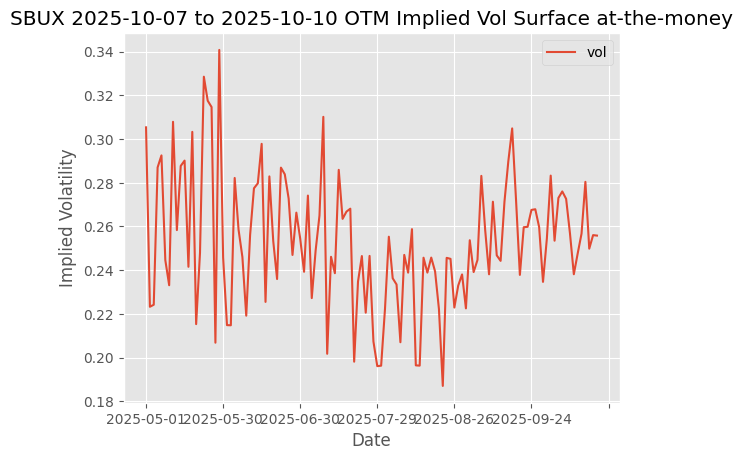

In [54]:
vols_1.droplevel('strike').reset_index().plot(y='vol',
                                                    x = 'Datetime',
                                                    title='SBUX 2025-10-07 to 2025-10-10 OTM Implied Vol Surface at-the-money', 
                                                    ylabel='Implied Volatility', 
                                                    xlabel='Date')

In [55]:
v_cols = ['spot', 'strike', 'f_log_moneyness', 'right', 'vol', 'moneyness', 'f']

In [56]:
df_chain = ts._model_set['2025-10-13'].chain.chain.copy()


clip = df_chain[(df_chain['dte']==95) & 
        (df_chain['f_log_moneyness'].between(-0.1, 0.1))
         ].head(5)[v_cols].copy().sort_values('strike')

clip

,spot,strike,f_log_moneyness,right,vol,moneyness,f
datetime,,,,,,,
2025-10-13,25.59,24.0,-0.063349,c,0.312196,0.937866,25.569563
2025-10-13,25.59,24.0,-0.063349,p,0.262204,0.937866,25.569563
2025-10-13,25.59,25.0,-0.022527,p,0.255955,0.976944,25.569563
2025-10-13,25.59,25.0,-0.022527,c,0.285075,0.976944,25.569563
2025-10-13,25.59,26.0,0.016694,c,0.271328,1.016022,25.569563


In [57]:
df_chain = ts._model_set['2025-10-10'].chain.chain.copy()
clip_2 = df_chain[(df_chain['dte']==98) & 
        (df_chain['f_log_moneyness'].between(-0.1, 0.1))
         ].head(5)[v_cols].copy().sort_values('strike')

clip_2

,spot,strike,f_log_moneyness,right,vol,moneyness,f
datetime,,,,,,,
2025-10-10,25.870001,24.0,-0.085368,p,0.291074,0.927715,26.138831
2025-10-10,25.870001,24.0,-0.085368,c,0.274452,0.927715,26.138831
2025-10-10,25.870001,25.0,-0.044546,p,0.280451,0.966370,26.138831
2025-10-10,25.870001,25.0,-0.044546,c,0.253831,0.966370,26.138831
2025-10-10,25.870001,26.0,-0.005325,p,0.276452,1.005025,26.138831


In [58]:
EODMarketSSVIModel.instances()

{('T', '2025-05-01'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-01>,
 ('T', '2025-05-02'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-02>,
 ('T', '2025-05-05'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-05>,
 ('T', '2025-05-06'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-06>,
 ('T', '2025-05-07'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-07>,
 ('T', '2025-05-08'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-08>,
 ('T', '2025-05-09'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-09>,
 ('T', '2025-05-12'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-12>,
 ('T', '2025-05-13'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-13>,
 ('T', '2025-05-14'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-14>,
 ('T', '2025-05-15'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-15>,
 ('T', '2025-05-16'): <EODMarketSSVIModel(symbol=T, valuation_date=2025-05-16>,
 ('T', '2025-05-19'): <EODMarketSSVIMode

In [59]:
GLOBAL_BACKGROUND_FITS.status()
# PARAMS_DUMP_CACHE.keys()
EODMarketSSVIModel(
    symbol='T',
    valuation_date='2025-10-16'
).chain.chain

2025-10-19 00:47:10 SSVIModel INFO: Using cached instance for T on 2025-10-16


,root,expiration,strike,right,bid_size,closebid,ask_size,closeask,date,midpoint,...,f,div_pv,f_moneyness,f_log_moneyness,intrinsic_value,eu_lower_bound,lower_bound,upper_bound,vol,config_hash
datetime,,,,,,,,,,,,,,,,,,,,,
2025-10-16,T,2026-01-16,29.0,c,350,0.46,1462,0.48,20251016,0.470,...,26.180190,0.275486,1.107708,0.102293,0.000000,0.000000,0.000000,26.202499,0.267453,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-01-16,29.0,p,1473,3.00,139,3.25,20251016,3.125,...,26.180190,0.275486,1.107708,0.102293,2.819810,2.792541,2.792541,29.000000,0.232210,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-01-16,34.0,c,2549,0.03,2374,0.13,20251016,0.080,...,26.180190,0.275486,1.298692,0.261357,0.000000,0.000000,0.000000,26.202499,0.304197,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-01-16,18.0,c,571,8.05,480,8.80,20251016,8.425,...,26.180190,0.275486,0.687543,-0.374631,8.180190,8.101083,8.101083,26.202499,0.597396,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-01-16,18.0,p,1343,0.01,1827,0.15,20251016,0.080,...,26.180190,0.275486,0.687543,-0.374631,0.000000,0.000000,0.000000,18.000000,0.432799,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-16,T,2026-06-18,25.0,p,1206,1.55,3250,1.74,20251016,1.645,...,26.326687,0.548366,0.949607,-0.051707,0.000000,0.000000,0.000000,25.000000,0.273827,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-06-18,30.0,c,702,0.89,608,0.96,20251016,0.925,...,26.326687,0.548366,1.139528,0.130614,0.000000,0.000000,0.000000,26.202499,0.255330,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...
2025-10-16,T,2026-06-18,18.0,c,762,8.40,851,8.95,20251016,8.675,...,26.326687,0.548366,0.683717,-0.380211,8.326687,8.113970,8.113970,26.202499,0.438548,5d2f204cca67fbf759fec9dbf0f9dbe6e6fb941e004328...


In [60]:
%load_ext autoreload
%autoreload 2
from algo.positions.loaders.position_vars import get_position_data
from algo.positions.loaders.option_data import get_orders_table
pos = get_position_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl
2025-10-19 00:47:12 DataManager.py CRITICAL: Using ProcessSaveManager for saving data.
[get_engine] Creating engine for DB: portfolio_data, PID: 25839


Loading BokehJS ...

[get_engine] Creating engine for DB: securities_master, PID: 25839
YF.download() has changed argument auto_adjust default to True
2025-10-19 00:47:44 trade.asset.Stock ERROR: Error getting dividends history for AMD from yfinance
2025-10-19 00:47:44 trade.asset.Stock ERROR: Probably due to no dividends history


KeyboardInterrupt: 

In [ ]:
import sys

total_size = 0
for name, obj in globals().items():
    try:
        total_size += sys.getsizeof(obj)
    except TypeError:
        pass  # some built-ins don't support getsizeof

print(f"Approximate total size of objects in memory: {total_size / 1024**2:.2f} MB")


Approximate total size of objects in memory: 1.29 MB


In [ ]:
import psutil, os

process = psutil.Process(os.getpid())
print(f"Total memory used by this Jupyter process: {process.memory_info().rss / 1024**2:.2f} MB")

Total memory used by this Jupyter process: 551.62 MB


In [ ]:
from pympler import asizeof

extra = [
    'PARAMS_DUMP_CACHE',
    'ts',
    'CHAIN_DUMP_CACHE',
    'bac_model',
    'EODMarketSSVIModel'
]
skip = {'In', 'Out', 'exit', 'quit', 'get_ipython', 'logger'}

total_size = 0
for name, obj in globals().items():
    if not name.startswith('_'):  # skip internals
        try:
            if name not in skip:
                total_size += asizeof.asizeof(obj)
            if asizeof.asizeof(obj) > 10*1024**2:
                print(f"Size of {name}: {asizeof.asizeof(obj) / 1024**2:.2f} MB")
            if name in extra:
                print(f"Size of {name}: {asizeof.asizeof(obj) / 1024**2:.2f} MB")
        except Exception:
            pass

print(f"Deep size of all variables: {total_size / 1024**2:.2f} MB")


Size of Out: 29.41 MB
Size of exit: 29.41 MB
Size of quit: 29.41 MB
Size of logger: 29.41 MB
Size of PARAMS_DUMP_CACHE: 0.01 MB
Size of CHAIN_DUMP_CACHE: 0.01 MB
Size of EODMarketSSVIModel: 0.00 MB
Size of bac_model: 0.00 MB
Size of ts: 0.00 MB
Size of pos: 29.41 MB
Deep size of all variables: 31.22 MB


In [ ]:
from pympler import asizeof
import psutil, os

# print(f"Deep Python object total: {sum(asizeof.asizeof(v) for v in globals().values()) / 1024**2:.2f} MB")
print(f"Full process memory (RSS): {psutil.Process(os.getpid()).memory_info().rss / 1024**2:.2f} MB")


Full process memory (RSS): 545.51 MB


In [ ]:
%whos


Variable                            Type                    Data/Info
---------------------------------------------------------------------
ABC                                 ABCMeta                 <class 'abc.ABC'>
Any                                 _AnyMeta                typing.Any
BackgroundFits                      type                    <class '__main__.BackgroundFits'>
BaseModel                           ModelMetaclass          <class 'pydantic.main.BaseModel'>
BaseSSVIModel                       ABCMeta                 <class '__main__.BaseSSVIModel'>
CHAIN_DUMP_CACHE                    CustomCache             <CustomCache 214 entries;<...>[612 rows x 29 columns]}>
Callable                            _CallableType           typing.Callable
ChainChecklist                      type                    <class '__main__.ChainChecklist'>
ChainInputModel                     ABCMeta                 <class '__main__.ChainInputModel'>
ChainOutput                         type         

In [ ]:
'PARAMS_DUMP_CACHE' in globals().keys()

True